In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import time
import random

from tensorflow.keras.datasets import mnist
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Mounting Google drive
#from google.colab import drive
#drive.mount('/content/drive')

### **Q1. Dataset Creation using the MNIST Dataset**

## **(a) Obtain foreground segmentation masks for the images in the MNIST dataset using Otsu’s thresholding. Using these rough binary masks as ground truth, build a new foreground segmentation dataset.**

In [3]:
# Create directories
print("Creating directories...")
os.makedirs('foreground_segmentation/train/images', exist_ok = True)
os.makedirs('foreground_segmentation/train/masks', exist_ok = True)
os.makedirs('foreground_segmentation/test/images', exist_ok = True)
os.makedirs('foreground_segmentation/test/masks', exist_ok = True)

Creating directories...


In [4]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Train samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train samples: 60000
Test samples: 10000


In [5]:
# Function to apply Otsu's thresholding
def apply_otsu(image):
    _, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

In [6]:
# Process and save training data
print("\nProcessing training data...")
for i in tqdm(range(len(x_train))):
    image = x_train[i]
    mask = apply_otsu(image)

    # Save image and mask (no label needed)
    Image.fromarray(image).save(f'foreground_segmentation/train/images/{i:06d}.png')
    Image.fromarray(mask).save(f'foreground_segmentation/train/masks/{i:06d}.png')

# Process and save test data
print("Processing test data...")
for i in tqdm(range(len(x_test))):
    image = x_test[i]
    mask = apply_otsu(image)

    # Save image and mask (no label needed)
    Image.fromarray(image).save(f'foreground_segmentation/test/images/{i:06d}.png')
    Image.fromarray(mask).save(f'foreground_segmentation/test/masks/{i:06d}.png')


Processing training data...


100%|██████████| 60000/60000 [00:26<00:00, 2266.08it/s]


Processing test data...


100%|██████████| 10000/10000 [00:04<00:00, 2198.04it/s]



Creating visualization...


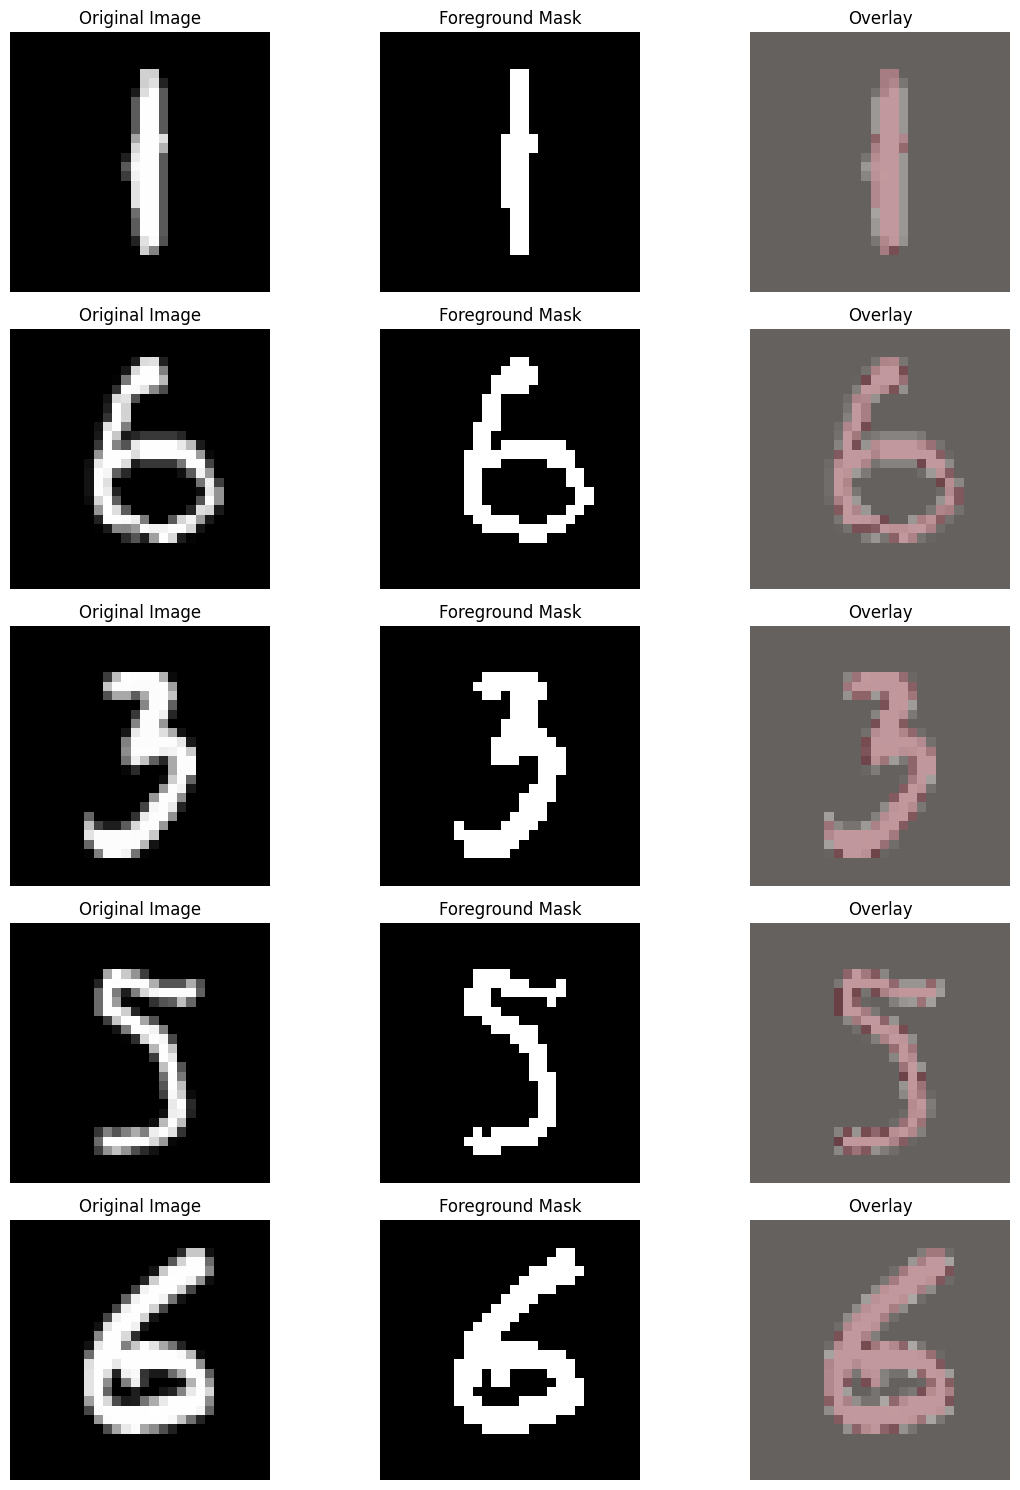


Foreground Segmentation Dataset Created Successfully
Location: foreground_segmentation/
├── train/
│   ├── images/  (60,000 images)
│   └── masks/   (60,000 binary masks)
└── test/
    ├── images/  (10,000 images)
    └── masks/   (10,000 binary masks)

Binary masks --> White (255) is Foreground, and Black (0) is Background


In [48]:
# Visualize samples
print("\nCreating visualization...")
fig, axes = plt.subplots(5, 3, figsize=(12, 15))

for i in range(5):
    idx = np.random.randint(0, len(x_train))
    image = x_train[idx]
    mask = apply_otsu(image)

    # Original image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Binary mask (foreground segmentation)
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Foreground Mask')
    axes[i, 1].axis('off')

    # Overlay
    axes[i, 2].imshow(image, cmap='gray')
    axes[i, 2].imshow(mask, cmap='Reds', alpha=0.4)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('foreground_segmentation/visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("Foreground Segmentation Dataset Created Successfully")
print("="*60)
print("Location: foreground_segmentation/")
print("├── train/")
print("│   ├── images/  (60,000 images)")
print("│   └── masks/   (60,000 binary masks)")
print("└── test/")
print("    ├── images/  (10,000 images)")
print("    └── masks/   (10,000 binary masks)")
print("\nBinary masks --> White (255) is Foreground, and Black (0) is Background")

## **(b) For each ground truth segmentation mask obtained in part (a), generate a tight enclosing circle around the mask. Build a new dataset with 10 classes, where each sample contains the image and its corresponding circular ground truth mask, for performing classification with circlization.**

In [8]:
# Create directories - both organized by class AND all together
print("Creating directories...")
for split in ['train', 'test']:
    # Organized by class
    for class_id in range(10):
        os.makedirs(f'circular_classification/{split}/class_{class_id}/images', exist_ok = True)
        os.makedirs(f'circular_classification/{split}/class_{class_id}/masks', exist_ok = True)
    # All together
    os.makedirs(f'circular_classification/{split}/all/images', exist_ok = True)
    os.makedirs(f'circular_classification/{split}/all/masks', exist_ok = True)

Creating directories...


In [9]:
# Function to get tight enclosing circle
def get_circular_mask(otsu_mask):
    """Generate tight circular mask from Otsu mask"""
    contours, _ = cv2.findContours(otsu_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        h, w = otsu_mask.shape
        center = (w // 2, h // 2)
        radius = min(h, w) // 4
    else:
        all_points = np.vstack(contours)
        (cx, cy), r = cv2.minEnclosingCircle(all_points)
        center = (int(cx), int(cy))
        radius = int(r)

    circular_mask = np.zeros_like(otsu_mask, dtype = np.uint8)
    cv2.circle(circular_mask, center, radius, 255, -1)

    return circular_mask, center, radius

In [10]:
# Process training data
print("\nProcessing training data...")
class_counters = {i: 0 for i in range(10)}

for i in tqdm(range(len(x_train))):
    image = x_train[i]
    label = int(y_train[i])

    # Get Otsu mask then circular mask
    otsu_mask = apply_otsu(image)
    circular_mask, _, _ = get_circular_mask(otsu_mask)

    # Save in class-specific folder
    idx = class_counters[label]
    Image.fromarray(image).save(
        f'circular_classification/train/class_{label}/images/{idx:06d}.png'
    )
    Image.fromarray(circular_mask).save(
        f'circular_classification/train/class_{label}/masks/{idx:06d}.png'
    )

    # Also save in combined folder with label in filename
    Image.fromarray(image).save(
        f'circular_classification/train/all/images/{i:06d}_class{label}.png'
    )
    Image.fromarray(circular_mask).save(
        f'circular_classification/train/all/masks/{i:06d}_class{label}.png'
    )

    class_counters[label] += 1

# Process test data
print("Processing test data...")
class_counters = {i: 0 for i in range(10)}

for i in tqdm(range(len(x_test))):
    image = x_test[i]
    label = int(y_test[i])

    # Get Otsu mask then circular mask
    otsu_mask = apply_otsu(image)
    circular_mask, _, _ = get_circular_mask(otsu_mask)

    # Save in class-specific folder
    idx = class_counters[label]
    Image.fromarray(image).save(
        f'circular_classification/test/class_{label}/images/{idx:06d}.png'
    )
    Image.fromarray(circular_mask).save(
        f'circular_classification/test/class_{label}/masks/{idx:06d}.png'
    )

    # Also save in combined folder
    Image.fromarray(image).save(
        f'circular_classification/test/all/images/{i:06d}_class{label}.png'
    )
    Image.fromarray(circular_mask).save(
        f'circular_classification/test/all/masks/{i:06d}_class{label}.png'
    )

    class_counters[label] += 1


Processing training data...


100%|██████████| 60000/60000 [00:57<00:00, 1040.36it/s]


Processing test data...


100%|██████████| 10000/10000 [00:09<00:00, 1098.74it/s]



Creating visualization...



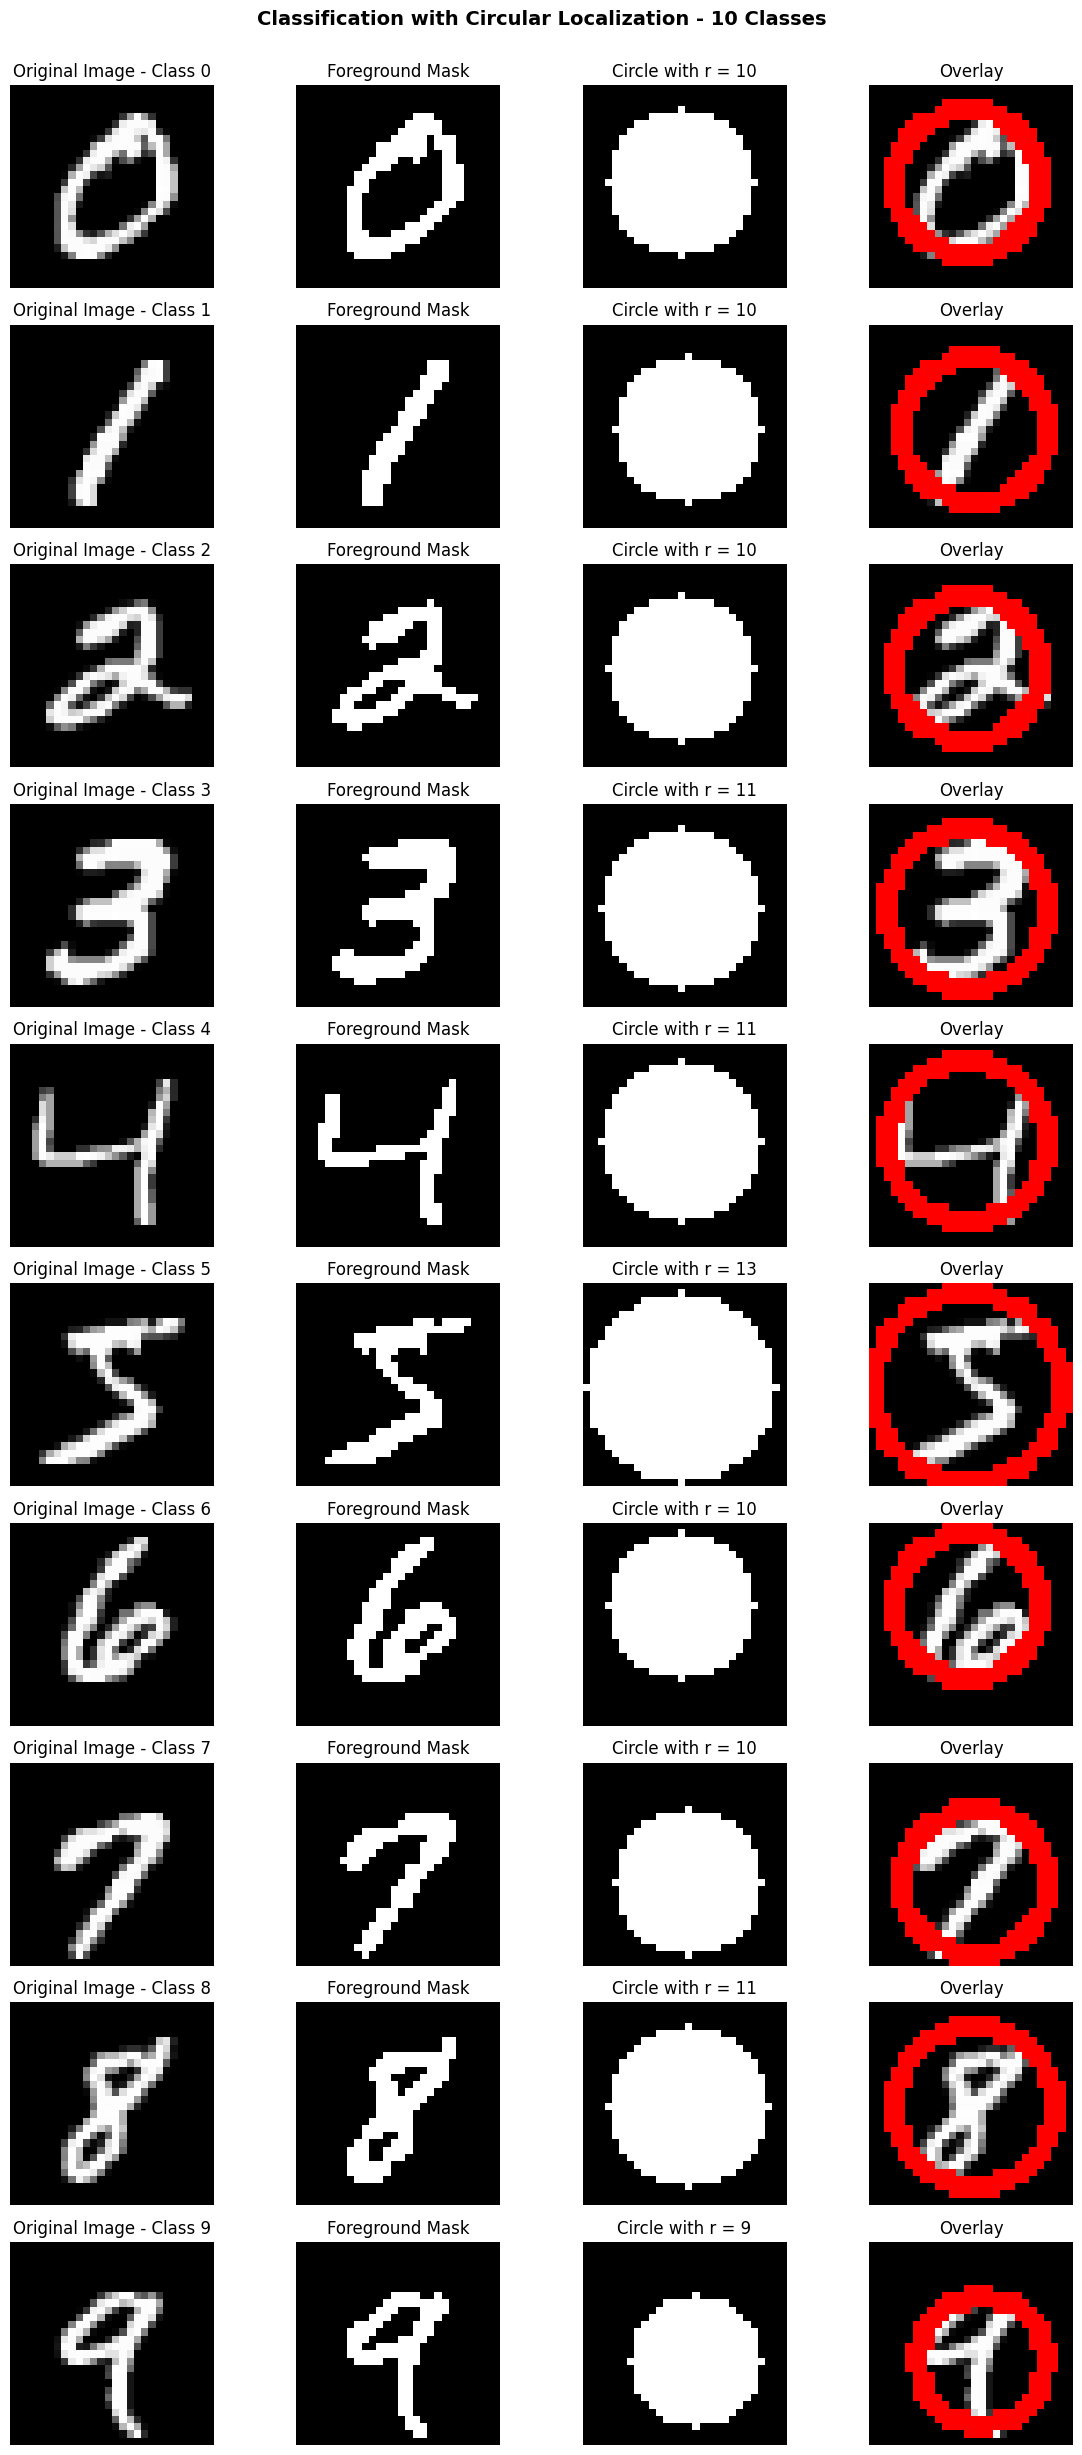


Circular Classification Dataset Created

Dataset: circular_classification/
├── train/
│   ├── class_0/ ... class_9/ (organized by digit)
│   └── all/                  (all samples together)
└── test/
    ├── class_0/ ... class_9/
    └── all/                  (all samples together)

Class    Train      Test      
------------------------------
0        5923       980       
1        6742       1135      
2        5958       1032      
3        6131       1010      
4        5842       982       
5        5421       892       
6        5918       958       
7        6265       1028      
8        5851       974       
9        5949       1009      
Circular masks created using cv2.minEnclosingCircle


In [11]:
# Visualize
print("\nCreating visualization...\n")
fig, axes = plt.subplots(10, 4, figsize = (12, 25))
fig.suptitle('Classification with Circular Localization - 10 Classes',
             fontsize = 14, fontweight = 'bold')

for class_id in range(10):
    idx = np.where(y_train == class_id)[0][0]
    image = x_train[idx]
    otsu_mask = apply_otsu(image)
    circular_mask, center_coords, radius = get_circular_mask(otsu_mask)
    cx, cy = center_coords # Unpack cx and cy from center_coords

    axes[class_id, 0].imshow(image, cmap='gray')
    axes[class_id, 0].set_title(f'Original Image - Class {class_id}')
    axes[class_id, 0].axis('off')

    axes[class_id, 1].imshow(otsu_mask, cmap='gray')
    axes[class_id, 1].set_title('Foreground Mask')
    axes[class_id, 1].axis('off')

    axes[class_id, 2].imshow(circular_mask, cmap='gray')
    axes[class_id, 2].set_title(f'Circle with r = {radius}')
    axes[class_id, 2].axis('off')

    overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    cv2.circle(overlay, (cx, cy), radius, (255, 0, 0), 2)
    axes[class_id, 3].imshow(overlay)
    axes[class_id, 3].set_title('Overlay')
    axes[class_id, 3].axis('off')

plt.tight_layout()
plt.subplots_adjust(top = 0.95)
plt.savefig('circular_classification/visualization.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print("\n" + "="*70)
print("Circular Classification Dataset Created")
print("="*70)
print("\nDataset: circular_classification/")
print("├── train/")
print("│   ├── class_0/ ... class_9/ (organized by digit)")
print("│   └── all/                  (all samples together)")
print("└── test/")
print("    ├── class_0/ ... class_9/")
print("    └── all/                  (all samples together)")
print("\n" + "="*70)
print(f"{'Class':<8} {'Train':<10} {'Test':<10}")
print("-" * 30)
for i in range(10):
    print(f"""{i:<8} {np.sum(y_train==i):<10} {np.sum(y_test==i):<10}""")
print("="*70)
print("Circular masks created using cv2.minEnclosingCircle")
print("="*70)

## **(c) Randomly concatenate four images and their corresponding ground truths in a 2×2 grid to create new images containing four digits. In this way, build a new dataset with 10 classes for performing semantic segmentation. Note: Ensure that no two generated images are identical, and that the final dataset contains atleast 0.25 million images.**

In [12]:
# Create directories for semantic segmentation dataset
print("\nCreating directories for semantic segmentation dataset...")
os.makedirs('semantic_segmentation/train/images', exist_ok = True)
os.makedirs('semantic_segmentation/train/masks', exist_ok = True)
os.makedirs('semantic_segmentation/test/images', exist_ok = True)
os.makedirs('semantic_segmentation/test/masks', exist_ok = True)


Creating directories for semantic segmentation dataset...


In [13]:
def create_2x2_grid(images, masks, labels):
    """
    Concatenate 4 images and masks in a 2×2 grid.
    Returns: grid_image, semantic_mask, and label info
    """
    # Each MNIST image is 28x28, so grid will be 56x56
    grid_image = np.zeros((56, 56), dtype = np.uint8)
    semantic_mask = np.zeros((56, 56), dtype = np.uint8)

    positions = [(0, 0), (0, 28), (28, 0), (28, 28)]  # Top-left, Top-right, Bottom-left, Bottom-right

    for idx, (i, j) in enumerate(positions):
        # Place image
        grid_image[i:i+28, j:j+28] = images[idx]

        # Place semantic mask with class label (class_id + 1, where 0 is background)
        # Each digit gets its own class: digit 0 -> class 1, digit 1 -> class 2, etc.
        class_id = labels[idx] + 1  # +1 because 0 is background
        mask_binary = masks[idx]
        semantic_mask[i:i+28, j:j+28][mask_binary > 0] = class_id

    return grid_image, semantic_mask, labels

In [14]:
def generate_unique_combinations(data_size, num_samples, seed = 42):
    """
    Generate unique combinations of 4 indices.
    Returns set of tuples to ensure uniqueness.
    """
    random.seed(seed)
    np.random.seed(seed)

    combinations = set()
    attempts = 0
    max_attempts = num_samples * 10  # Prevent infinite loop

    print(f"Generating {num_samples:,} unique combinations...")
    pbar = tqdm(total = num_samples)

    while len(combinations) < num_samples and attempts < max_attempts:
        # Randomly select 4 different indices
        indices = tuple(sorted(np.random.choice(data_size, 4, replace=False)))

        if indices not in combinations:
            combinations.add(indices)
            pbar.update(1)

        attempts += 1

    pbar.close()

    if len(combinations) < num_samples:
        print(f"Warning: Only generated {len(combinations)} unique combinations")

    return list(combinations)

In [15]:
#Generate Otsu masks for all data
print("\nGenerating Otsu masks for training data...")
train_masks = np.array([apply_otsu(img) for img in tqdm(x_train)])

print("Generating Otsu masks for test data...")
test_masks = np.array([apply_otsu(img) for img in tqdm(x_test)])

# Generate training set (200,000 images)
print("\n" + "="*70)
print("Creating Semantic Segmentation Training Set")
print("="*70)

num_train_samples = 200000
train_combinations = generate_unique_combinations(len(x_train), num_train_samples, seed = 42)

print(f"\nCreating {num_train_samples:,} training images...")

for idx, combination in enumerate(tqdm(train_combinations)):
    # Get 4 images, masks, and labels
    indices = list(combination)
    images  = [x_train[i] for i in indices]
    masks   = [train_masks[i] for i in indices]
    labels  = [int(y_train[i]) for i in indices]

    # Create 2×2 grid
    grid_image, semantic_mask, digit_labels = create_2x2_grid(images, masks, labels)

    # Save
    Image.fromarray(grid_image).save(f'semantic_segmentation/train/images/{idx:06d}.png')
    Image.fromarray(semantic_mask).save(f'semantic_segmentation/train/masks/{idx:06d}.png')

# Generate test set (50,000 images)
print("\n" + "="*70)
print("Creating Semantic Segmentation Test Set")
print("="*70)

num_test_samples = 50000
test_combinations = generate_unique_combinations(len(x_test), num_test_samples, seed = 123)

print(f"\nCreating {num_test_samples:,} test images...")

for idx, combination in enumerate(tqdm(test_combinations)):
    # Get 4 images, masks, and labels
    indices = list(combination)
    images  = [x_test[i] for i in indices]
    masks   = [test_masks[i] for i in indices]
    labels  = [int(y_test[i]) for i in indices]

    # Create 2×2 grid
    grid_image, semantic_mask, digit_labels = create_2x2_grid(images, masks, labels)

    # Save
    Image.fromarray(grid_image).save(f'semantic_segmentation/test/images/{idx:06d}.png')
    Image.fromarray(semantic_mask).save(f'semantic_segmentation/test/masks/{idx:06d}.png')



Generating Otsu masks for training data...


100%|██████████| 60000/60000 [00:00<00:00, 165606.14it/s]


Generating Otsu masks for test data...


100%|██████████| 10000/10000 [00:00<00:00, 169410.70it/s]



Creating Semantic Segmentation Training Set
Generating 200,000 unique combinations...


100%|██████████| 200000/200000 [03:11<00:00, 1042.43it/s]



Creating 200,000 training images...


100%|██████████| 200000/200000 [02:19<00:00, 1434.03it/s]



Creating Semantic Segmentation Test Set
Generating 50,000 unique combinations...


100%|██████████| 50000/50000 [00:09<00:00, 5385.02it/s]



Creating 50,000 test images...


100%|██████████| 50000/50000 [00:34<00:00, 1438.39it/s]



Creating visualization...



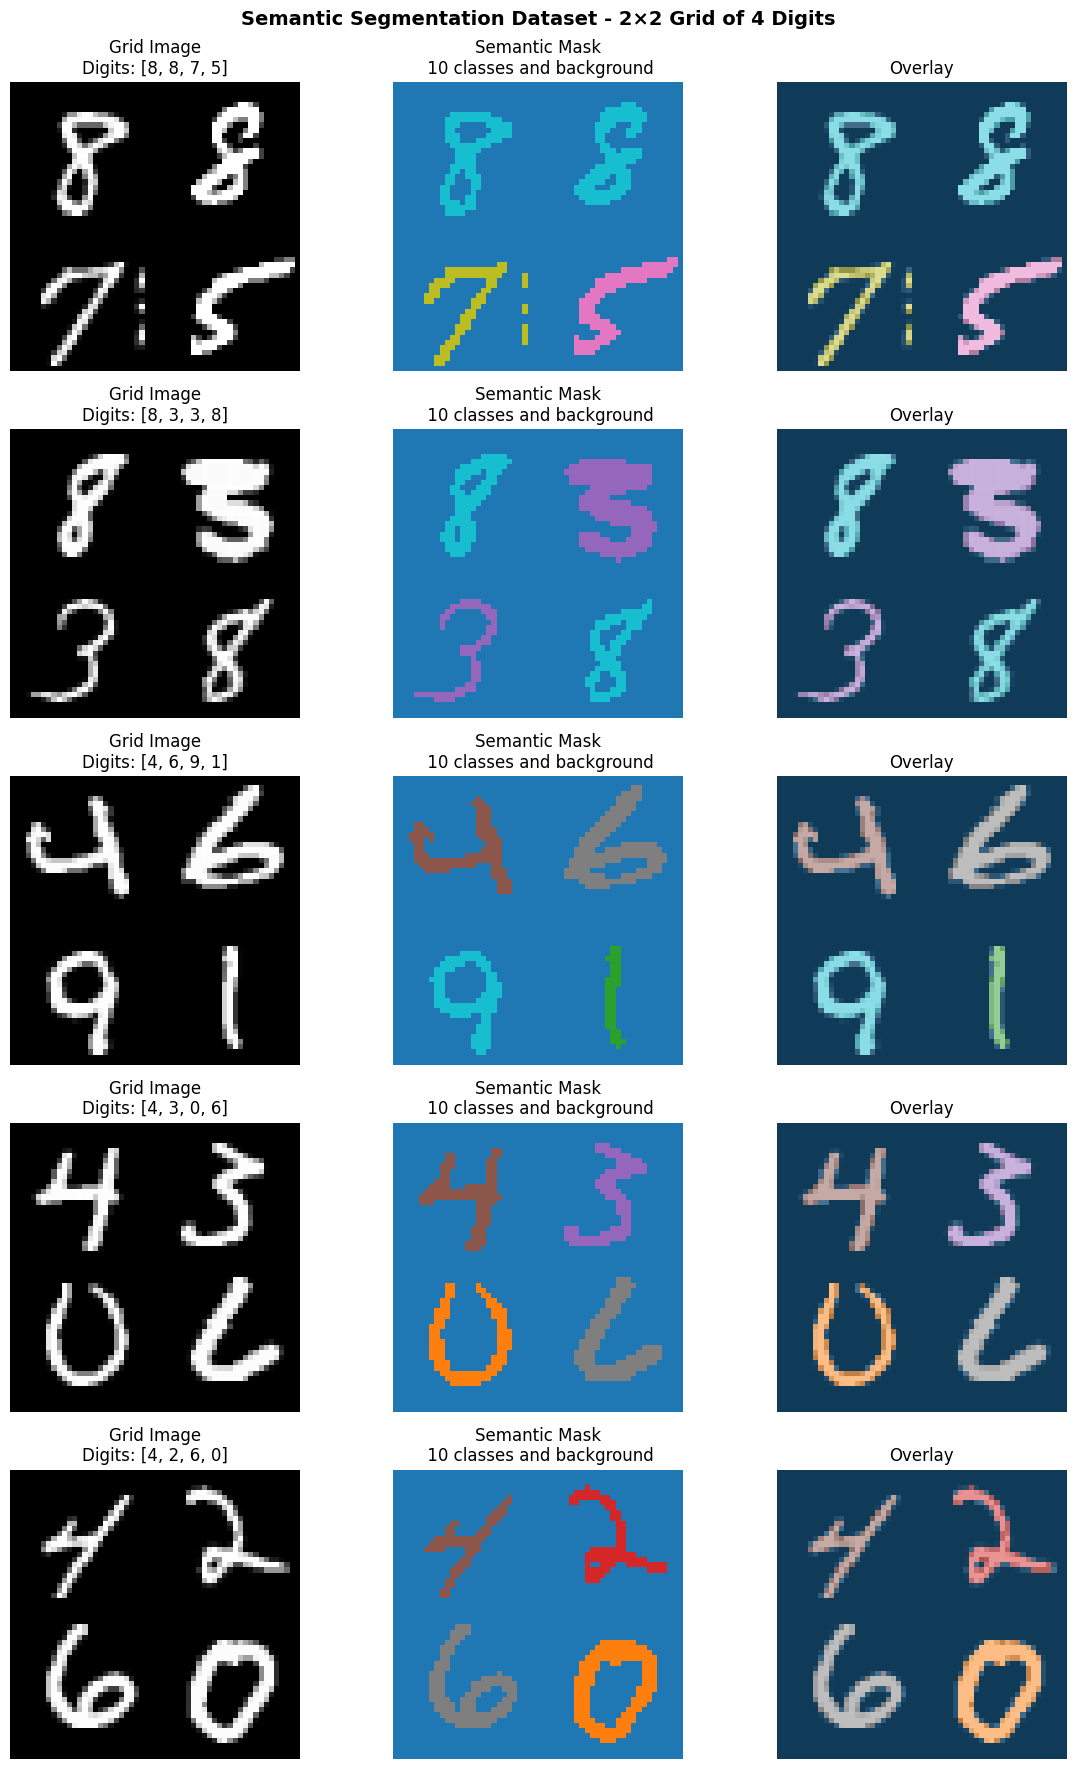

In [44]:
# Create visualization
print("\nCreating visualization...\n")
fig, axes = plt.subplots(5, 3, figsize=(12, 18))
fig.suptitle('Semantic Segmentation Dataset - 2×2 Grid of 4 Digits',
             fontsize=14, fontweight='bold')

for i in range(5):
    # Random sample from training set
    idx = np.random.randint(0, min(1000, len(train_combinations)))
    combination = train_combinations[idx]

    # Recreate the grid
    indices = list(combination)
    images  = [x_train[j] for j in indices]
    masks   = [train_masks[j] for j in indices]
    labels  = [int(y_train[j]) for j in indices]

    grid_image, semantic_mask, digit_labels = create_2x2_grid(images, masks, labels)

    # Original grid image
    axes[i, 0].imshow(grid_image, cmap='gray')
    axes[i, 0].set_title(f'Grid Image\nDigits: {digit_labels}')
    axes[i, 0].axis('off')

    # Semantic segmentation mask (with colors)
    axes[i, 1].imshow(semantic_mask, cmap='tab10', vmin = 0, vmax = 10)
    axes[i, 1].set_title('Semantic Mask\n 10 classes and background')
    axes[i, 1].axis('off')

    # Overlay
    axes[i, 2].imshow(grid_image, cmap='gray')
    axes[i, 2].imshow(semantic_mask, cmap='tab10', alpha = 0.5, vmin=0, vmax=10)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.subplots_adjust(top = 0.94)
plt.savefig('semantic_segmentation/visualization.png', dpi = 150, bbox_inches = 'tight')
plt.show()


Creating class distribution visualization...



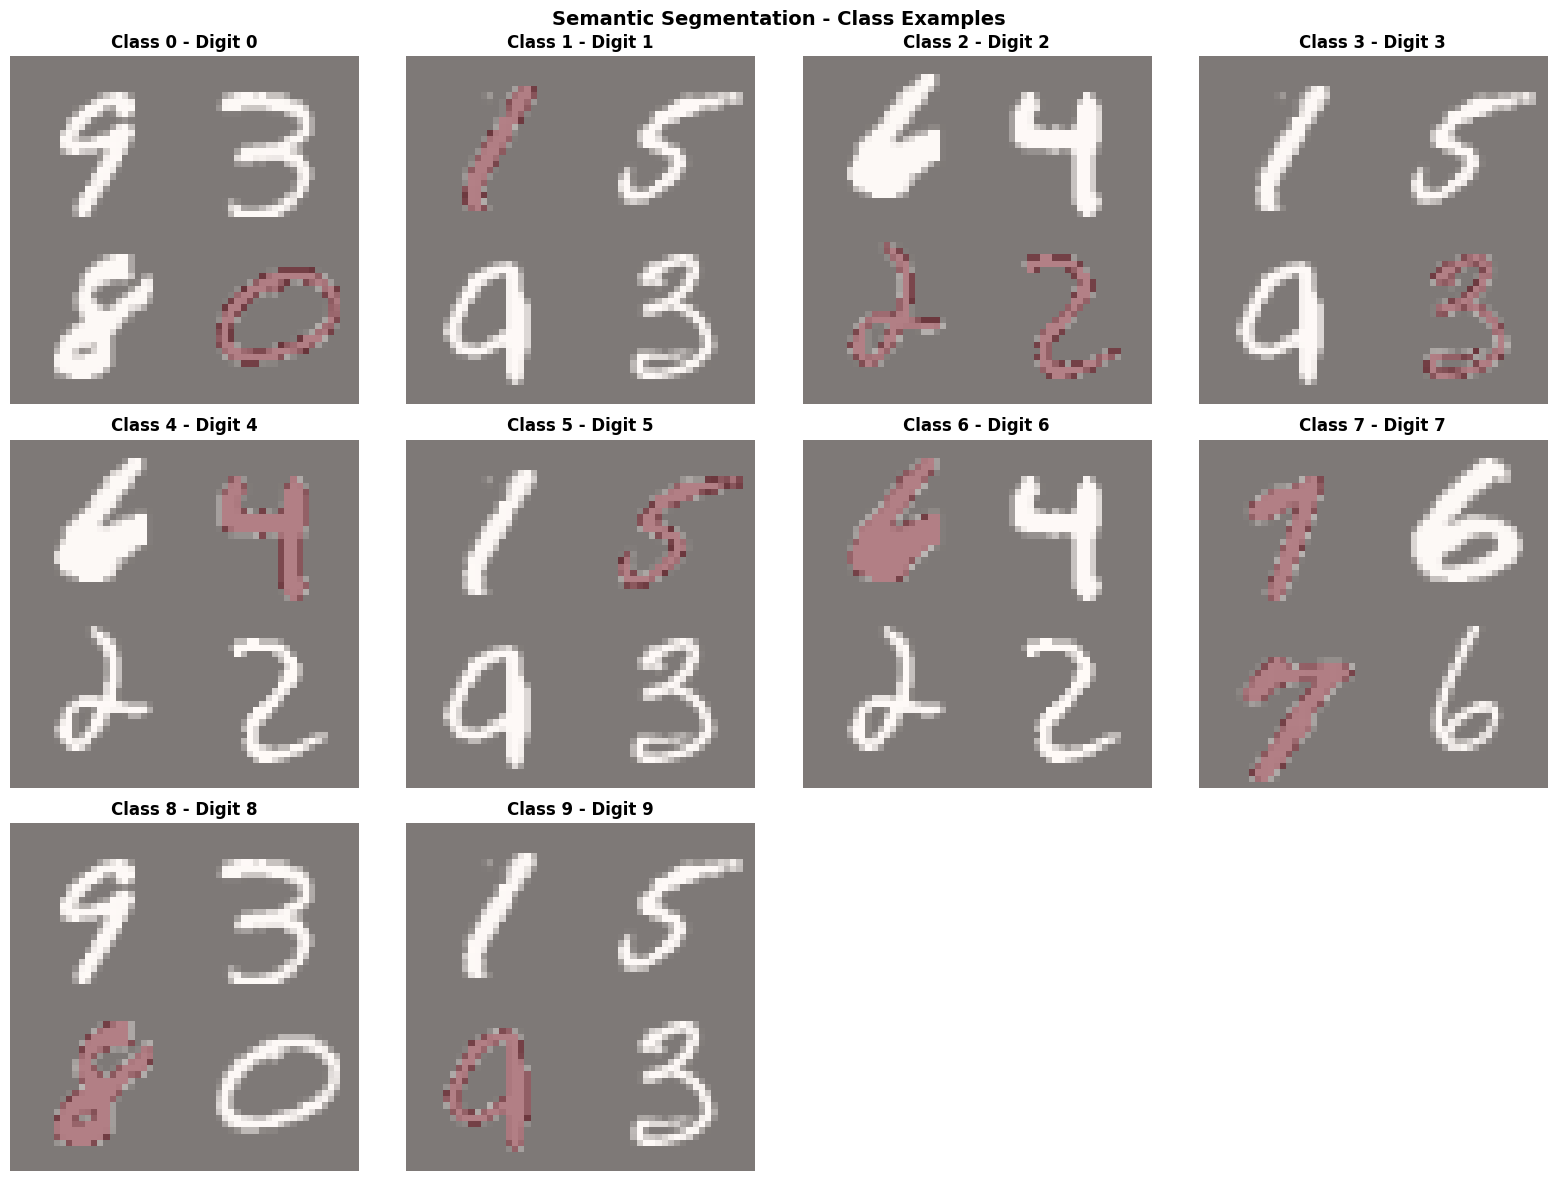


SEMANTIC SEGMENTATION DATASET CREATED SUCCESSFULLY!

Dataset Location: semantic_segmentation/

Dataset Size:
  Training images:   200,000
  Test images:       50,000
  Total images:      250,000

Image Specifications:
  Image size:        56×56 (2×2 grid of 28×28 MNIST digits)
  Images per sample: 4 digits randomly concatenated
  Uniqueness:        All combinations are unique

Semantic Segmentation Classes:
  Class 0:  Background
  Class 1:  Digit 0
  Class 2:  Digit 1
  Class 3:  Digit 2
  Class 4:  Digit 3
  Class 5:  Digit 4
  Class 6:  Digit 5
  Class 7:  Digit 6
  Class 8:  Digit 7
  Class 9:  Digit 8
  Class 10: Digit 9

Total Classes: 11 (10 digit classes + 1 background class)

Dataset Structure:
  semantic_segmentation/
  ├── train/
  │   ├── images/           (200,000 grid images)
  │   └── masks/            (200,000 semantic masks)
  ├── test/
  │   ├── images/           (50,000 grid images)
  │   └── masks/            (50,000 semantic masks)
  ├── visualization.png
  └── cl

In [17]:
# Create detailed class visualization
print("\nCreating class distribution visualization...\n")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Semantic Segmentation - Class Examples', fontsize = 14, fontweight = 'bold')

class_colors = plt.cm.tab10(np.linspace(0, 1, 11))

for class_id in range(10):
    row = class_id // 4
    col = class_id % 4

    # Find a sample containing this digit
    found = False
    for idx, combination in enumerate(train_combinations[:1000]):
        indices = list(combination)
        labels  = [int(y_train[j]) for j in indices]

        if class_id in labels:
            images = [x_train[j] for j in indices]
            masks  = [train_masks[j] for j in indices]
            grid_image, semantic_mask, _ = create_2x2_grid(images, masks, labels)

            # Highlight this class
            class_highlight = np.zeros_like(semantic_mask)
            class_highlight[semantic_mask == class_id + 1] = 255

            axes[row, col].imshow(grid_image, cmap = 'gray')
            axes[row, col].imshow(class_highlight, cmap = 'Reds', alpha = 0.5)
            axes[row, col].set_title(f'Class {class_id} - Digit {class_id}', fontweight = 'bold')
            axes[row, col].axis('off')
            found = True
            break

    if not found:
        axes[row, col].text(0.5, 0.5, f'Class {class_id}\nNot found in samples',
                           ha = 'center', va = 'center')
        axes[row, col].axis('off')

# Remove extra subplots
for idx in range(10, 12):
    row = idx // 4
    col = idx % 4
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.savefig('semantic_segmentation/class_visualization.png', dpi = 150, bbox_inches = 'tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("SEMANTIC SEGMENTATION DATASET CREATED SUCCESSFULLY!")
print("="*70)
print(f"\nDataset Location: semantic_segmentation/")
print(f"\nDataset Size:")
print(f"  Training images:   {num_train_samples:,}")
print(f"  Test images:       {num_test_samples:,}")
print(f"  Total images:      {num_train_samples + num_test_samples:,}")
print(f"\nImage Specifications:")
print(f"  Image size:        56×56 (2×2 grid of 28×28 MNIST digits)")
print(f"  Images per sample: 4 digits randomly concatenated")
print(f"  Uniqueness:        All combinations are unique")

print(f"\nSemantic Segmentation Classes:")
print(f"  Class 0:  Background")
print(f"  Class 1:  Digit 0")
print(f"  Class 2:  Digit 1")
print(f"  Class 3:  Digit 2")
print(f"  Class 4:  Digit 3")
print(f"  Class 5:  Digit 4")
print(f"  Class 6:  Digit 5")
print(f"  Class 7:  Digit 6")
print(f"  Class 8:  Digit 7")
print(f"  Class 9:  Digit 8")
print(f"  Class 10: Digit 9")
print(f"\nTotal Classes: 11 (10 digit classes + 1 background class)")

print(f"\nDataset Structure:")
print(f"  semantic_segmentation/")
print(f"  ├── train/")
print(f"  │   ├── images/           ({num_train_samples:,} grid images)")
print(f"  │   └── masks/            ({num_train_samples:,} semantic masks)")
print(f"  ├── test/")
print(f"  │   ├── images/           ({num_test_samples:,} grid images)")
print(f"  │   └── masks/            ({num_test_samples:,} semantic masks)")
print(f"  ├── visualization.png")
print(f"  └── class_visualization.png")

print("\n" + "="*70)
print("Mask Encoding:")
print("  - Background pixels: 0")
print("  - Digit pixels: class_id + 1 (where class_id is the digit 0-9)")
print("  - Each pixel indicates which class it belongs to")
print("="*70)

# Calculate statistics
print("\nCalculating dataset statistics...")
sample_masks = []
for i in range(min(1000, len(train_combinations))):
    combination = train_combinations[i]
    indices = list(combination)
    images  = [x_train[j] for j in indices]
    masks   = [train_masks[j] for j in indices]
    labels  = [int(y_train[j]) for j in indices]
    _, semantic_mask, _ = create_2x2_grid(images, masks, labels)
    sample_masks.append(semantic_mask)

sample_masks = np.array(sample_masks)

print(f"\nStatistics (from {len(sample_masks)} samples):")
for class_id in range(11):
    if class_id == 0:
        class_name = "Background"
    else:
        class_name = f"Digit {class_id - 1}"

    pixel_count = np.sum(sample_masks == class_id)
    percentage = (pixel_count / sample_masks.size) * 100
    print(f"  {class_name:<15} - {percentage:6.2f}% of pixels")

print("\n" + "="*70)
print(f"Successfully created {num_train_samples + num_test_samples:,} unique images!")
print("="*70)

# **Q2. Foreground Extraction**

## **Train a deep learning network from scratch to perform foreground extraction on the dataset created in Q1(a). Report your test performance using the Intersection over Union (IoU) metric.**

### **Data Loader for Foreground Segmentation Dataset**

In [18]:
class ForegroundSegmentationDataset(Dataset):
    """ Dataset class for foreground segmentation """

    def __init__(self, image_dir, mask_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_name = self.image_files[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert('L')
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')

        # Convert to numpy arrays
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
        mask = np.array(mask, dtype=np.float32) / 255.0    # Normalize to [0, 1]

        # Add channel dimension
        image = np.expand_dims(image, axis=0)  # (1, 28, 28)
        mask = np.expand_dims(mask, axis=0)    # (1, 28, 28)

        # Convert to torch tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

### **U-Net Architecture**

In [19]:
class UNet(nn.Module):
    """ U-Net architecture for binary segmentation """

    def __init__(self, in_channels = 1, out_channels = 1):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Expanding Path)
        # Add output_padding to match encoder feature map sizes due to non-power-of-2 input dimensions
        # Explicitly setting padding=0 to ensure correct dimensions, as it's the default but clarifies intent
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size = 1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def conv_block(self, in_channels, out_channels):
        """ Convolutional block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        # Output
        out = self.out(dec1)
        out = torch.sigmoid(out)  # Binary segmentation

        return out

### **IoU Metric Calculation**

In [20]:
def calculate_iou(pred, target, threshold = 0.5):
    """
    Calculate Intersection over Union (IoU) metric

    Args:
        pred: Predicted masks (B, 1, H, W)
        target: Ground truth masks (B, 1, H, W)
        threshold: Threshold to binarize predictions

    Returns:
        IoU score
    """
    # Binarize predictions
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)  # Add small epsilon to avoid division by zero

    return iou.mean().item()

### **Training Function**

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """ Train the segmentation model """

    print("\n" + "="*70)
    print("TRAINING FOREGROUND EXTRACTION MODEL")
    print("="*70)

    history = {
        'train_loss': [],
        'train_iou': [],
        'val_loss': [],
        'val_iou': []
    }

    best_val_iou = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_iou = 0.0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item()
            train_iou += calculate_iou(outputs, masks)

        train_loss /= len(train_loader)
        train_iou /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  '):
                images = images.to(device)
                masks = masks.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)

                # Calculate metrics
                val_loss += loss.item()
                val_iou += calculate_iou(outputs, masks)

        val_loss /= len(val_loader)
        val_iou /= len(val_loader)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f}")

        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_foreground_model.pth')
            print(f"Best model saved (Val IoU: {val_iou:.4f})")

        print("-" * 70)

    return history

### **Evaluation Function**

In [22]:
def evaluate_model(model, test_loader, device):
    """ Evaluate model on test set """

    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70)

    model.eval()
    test_iou = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc = 'Testing'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate IoU
            test_iou += calculate_iou(outputs, masks)

            # Store for visualization
            all_predictions.append(outputs.cpu())
            all_targets.append(masks.cpu())

    test_iou /= len(test_loader)

    print(f"\nTest IoU: {test_iou:.4f} ({test_iou*100:.2f}%)")
    print("="*70)

    return test_iou, all_predictions, all_targets


### **Visualization Functions**

In [23]:
def plot_training_history(history):
    """ Plot training history """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], label = 'Train Loss', marker = 'o')
    axes[0].plot(epochs, history['val_loss'], label = 'Val Loss', marker = 's')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].set_xticks(range(1, len(history['train_loss']) + 1, 1))
    axes[0].set_ylim(bottom = None)
    axes[0].grid(True)

    # IoU plot
    axes[1].plot(epochs, history['train_iou'], label = 'Train IoU', marker = 'o')
    axes[1].plot(epochs, history['val_iou'], label = 'Val IoU', marker = 's')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].set_title('Training and Validation IoU')
    axes[1].legend()
    axes[1].set_xticks(range(1, len(history['train_iou']) + 1, 1))
    axes[1].set_ylim(bottom = None)
    axes[1].grid(True)

    plt.suptitle('Training History Foreground Extraction', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    plt.savefig('training_history_foreground_extraction.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

    print("\nTraining history saved as 'training_history_foreground_extraction.png'")

In [24]:
def visualize_predictions(model, test_loader, device, num_samples = 10):
    """ Visualize model predictions """

    model.eval()

    # Get a batch of test data
    images, masks = next(iter(test_loader))
    images = images.to(device)

    with torch.no_grad():
        predictions = model(images)

    # Move to CPU for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # Plot predictions
    fig, axes = plt.subplots(num_samples, 4, figsize=(14, num_samples*3))

    for i in range(min(num_samples, len(images))):
        # Original image
        axes[i, 0].imshow(images[i, 0], cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0], cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(predictions[i, 0], cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(images[i, 0], cmap='gray')
        axes[i, 3].imshow(predictions[i, 0], cmap='Reds', alpha = 0.5)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

        # Calculate IoU for this sample
        pred_binary = (predictions[i, 0] > 0.5).astype(np.float32)
        mask_binary = (masks[i, 0] > 0.5).astype(np.float32)
        intersection = (pred_binary * mask_binary).sum()
        union = pred_binary.sum() + mask_binary.sum() - intersection
        iou = intersection / (union + 1e-7)

        axes[i, 0].set_ylabel(f'IoU: {iou:.3f}', fontsize = 12, fontweight = 'bold')

    plt.suptitle('Foreground Extraction Results', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.96)
    plt.savefig('prediction_results_foreground_extraction.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

    print("\nPredictions saved as 'prediction_results_foreground_extraction.png'")

## **Main Training Pipeline**


Using device: cuda

Preparing dataset...
Training samples: 54000
Validation samples: 6000
Test samples: 10000

Initializing U-Net model...
Total parameters: 31,042,369
Trainable parameters: 31,042,369

TRAINING FOREGROUND EXTRACTION MODEL


Epoch 1/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 30.13it/s]



Epoch 1/20 - Time: 80.02s
  Train Loss: 0.0257 | Train IoU: 0.9833
  Val Loss:   0.0033 | Val IoU:   0.9926
Best model saved (Val IoU: 0.9926)
----------------------------------------------------------------------


Epoch 2/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 29.68it/s]



Epoch 2/20 - Time: 82.75s
  Train Loss: 0.0031 | Train IoU: 0.9914
  Val Loss:   0.0040 | Val IoU:   0.9870
----------------------------------------------------------------------


Epoch 3/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.21it/s]



Epoch 3/20 - Time: 82.02s
  Train Loss: 0.0024 | Train IoU: 0.9926
  Val Loss:   0.0022 | Val IoU:   0.9930
Best model saved (Val IoU: 0.9930)
----------------------------------------------------------------------


Epoch 4/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.19it/s]



Epoch 4/20 - Time: 81.84s
  Train Loss: 0.0021 | Train IoU: 0.9932
  Val Loss:   0.0025 | Val IoU:   0.9916
----------------------------------------------------------------------


Epoch 5/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 30.00it/s]



Epoch 5/20 - Time: 81.88s
  Train Loss: 0.0019 | Train IoU: 0.9937
  Val Loss:   0.0020 | Val IoU:   0.9936
Best model saved (Val IoU: 0.9936)
----------------------------------------------------------------------


Epoch 6/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.39it/s]



Epoch 6/20 - Time: 81.73s
  Train Loss: 0.0018 | Train IoU: 0.9941
  Val Loss:   0.0017 | Val IoU:   0.9942
Best model saved (Val IoU: 0.9942)
----------------------------------------------------------------------


Epoch 7/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.45it/s]



Epoch 7/20 - Time: 81.98s
  Train Loss: 0.0017 | Train IoU: 0.9944
  Val Loss:   0.0028 | Val IoU:   0.9910
----------------------------------------------------------------------


Epoch 8/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 32.05it/s]



Epoch 8/20 - Time: 81.81s
  Train Loss: 0.0016 | Train IoU: 0.9947
  Val Loss:   0.0016 | Val IoU:   0.9942
Best model saved (Val IoU: 0.9942)
----------------------------------------------------------------------


Epoch 9/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.32it/s]



Epoch 9/20 - Time: 81.72s
  Train Loss: 0.0015 | Train IoU: 0.9950
  Val Loss:   0.0015 | Val IoU:   0.9949
Best model saved (Val IoU: 0.9949)
----------------------------------------------------------------------


Epoch 10/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.07it/s]



Epoch 10/20 - Time: 81.73s
  Train Loss: 0.0014 | Train IoU: 0.9952
  Val Loss:   0.0015 | Val IoU:   0.9947
----------------------------------------------------------------------


Epoch 11/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 31.13it/s]



Epoch 11/20 - Time: 81.98s
  Train Loss: 0.0014 | Train IoU: 0.9953
  Val Loss:   0.0013 | Val IoU:   0.9957
Best model saved (Val IoU: 0.9957)
----------------------------------------------------------------------


Epoch 12/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.37it/s]



Epoch 12/20 - Time: 81.57s
  Train Loss: 0.0013 | Train IoU: 0.9956
  Val Loss:   0.0018 | Val IoU:   0.9940
----------------------------------------------------------------------


Epoch 13/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 33.59it/s]



Epoch 13/20 - Time: 81.64s
  Train Loss: 0.0012 | Train IoU: 0.9959
  Val Loss:   0.0014 | Val IoU:   0.9951
----------------------------------------------------------------------


Epoch 14/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.03it/s]



Epoch 14/20 - Time: 81.49s
  Train Loss: 0.0012 | Train IoU: 0.9959
  Val Loss:   0.0012 | Val IoU:   0.9957
Best model saved (Val IoU: 0.9957)
----------------------------------------------------------------------


Epoch 15/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.24it/s]



Epoch 15/20 - Time: 81.61s
  Train Loss: 0.0011 | Train IoU: 0.9962
  Val Loss:   0.0013 | Val IoU:   0.9954
----------------------------------------------------------------------


Epoch 16/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 31.79it/s]



Epoch 16/20 - Time: 81.92s
  Train Loss: 0.0011 | Train IoU: 0.9963
  Val Loss:   0.0021 | Val IoU:   0.9936
----------------------------------------------------------------------


Epoch 17/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.46it/s]



Epoch 17/20 - Time: 81.59s
  Train Loss: 0.0010 | Train IoU: 0.9967
  Val Loss:   0.0011 | Val IoU:   0.9961
Best model saved (Val IoU: 0.9961)
----------------------------------------------------------------------


Epoch 18/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.35it/s]



Epoch 18/20 - Time: 81.67s
  Train Loss: 0.0010 | Train IoU: 0.9967
  Val Loss:   0.0013 | Val IoU:   0.9957
----------------------------------------------------------------------


Epoch 19/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 31.32it/s]



Epoch 19/20 - Time: 81.83s
  Train Loss: 0.0009 | Train IoU: 0.9969
  Val Loss:   0.0021 | Val IoU:   0.9942
----------------------------------------------------------------------


Epoch 20/20 [Val]  : 100%|██████████| 94/94 [00:02<00:00, 34.57it/s]



Epoch 20/20 - Time: 81.54s
  Train Loss: 0.0009 | Train IoU: 0.9971
  Val Loss:   0.0020 | Val IoU:   0.9943
----------------------------------------------------------------------

Plotting training history...



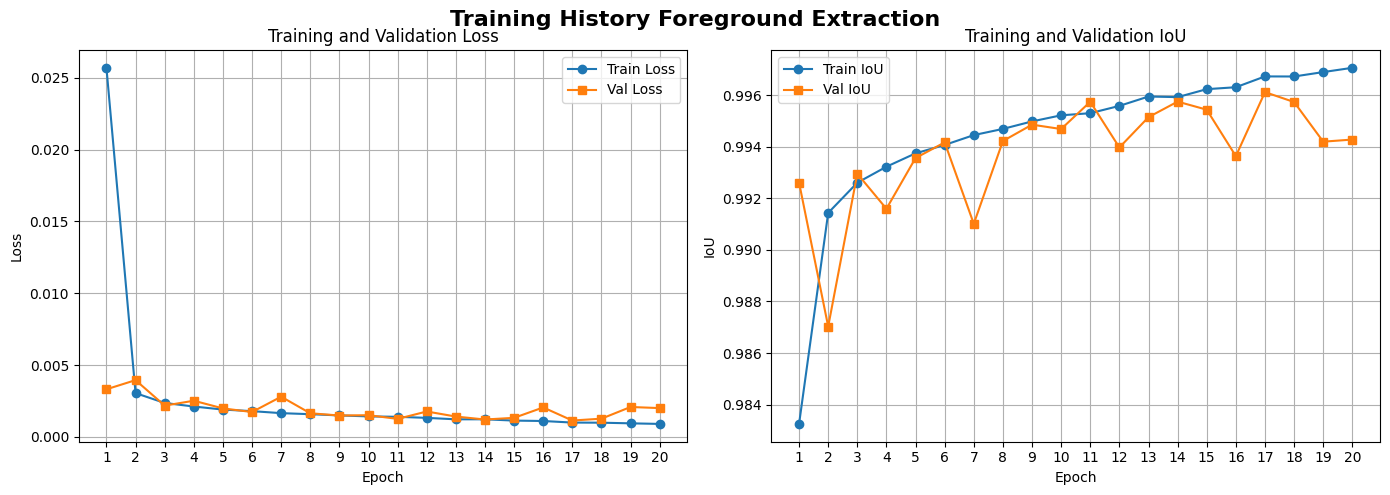


Training history saved as 'training_history_foreground_extraction.png'


In [25]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
VAL_SPLIT = 0.1

# Prepare dataset
print("\nPreparing dataset...")
train_image_dir = 'foreground_segmentation/train/images'
train_mask_dir = 'foreground_segmentation/train/masks'

# Get all image files
image_files = sorted(os.listdir(train_image_dir))

# Split into train and validation
train_files, val_files = train_test_split(image_files, test_size=VAL_SPLIT, random_state = 42)

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Create datasets
train_dataset = ForegroundSegmentationDataset(train_image_dir, train_mask_dir, train_files)
val_dataset = ForegroundSegmentationDataset(train_image_dir, train_mask_dir, val_files)

test_image_dir = 'foreground_segmentation/test/images'
test_mask_dir = 'foreground_segmentation/test/masks'
test_files = sorted(os.listdir(test_image_dir))
test_dataset = ForegroundSegmentationDataset(test_image_dir, test_mask_dir, test_files)

print(f"Test samples: {len(test_files)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

# Initialize model
print("\nInitializing U-Net model...")
model = UNet(in_channels = 1, out_channels = 1).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Train model
history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, device)

# Plot training history
print("\nPlotting training history...\n")
plot_training_history(history)

# **Visualize Predications**


Loading best model...

EVALUATING ON TEST SET


Testing: 100%|██████████| 157/157 [00:05<00:00, 28.92it/s]



Test IoU: 0.9963 (99.63%)
Visualizing predictions...



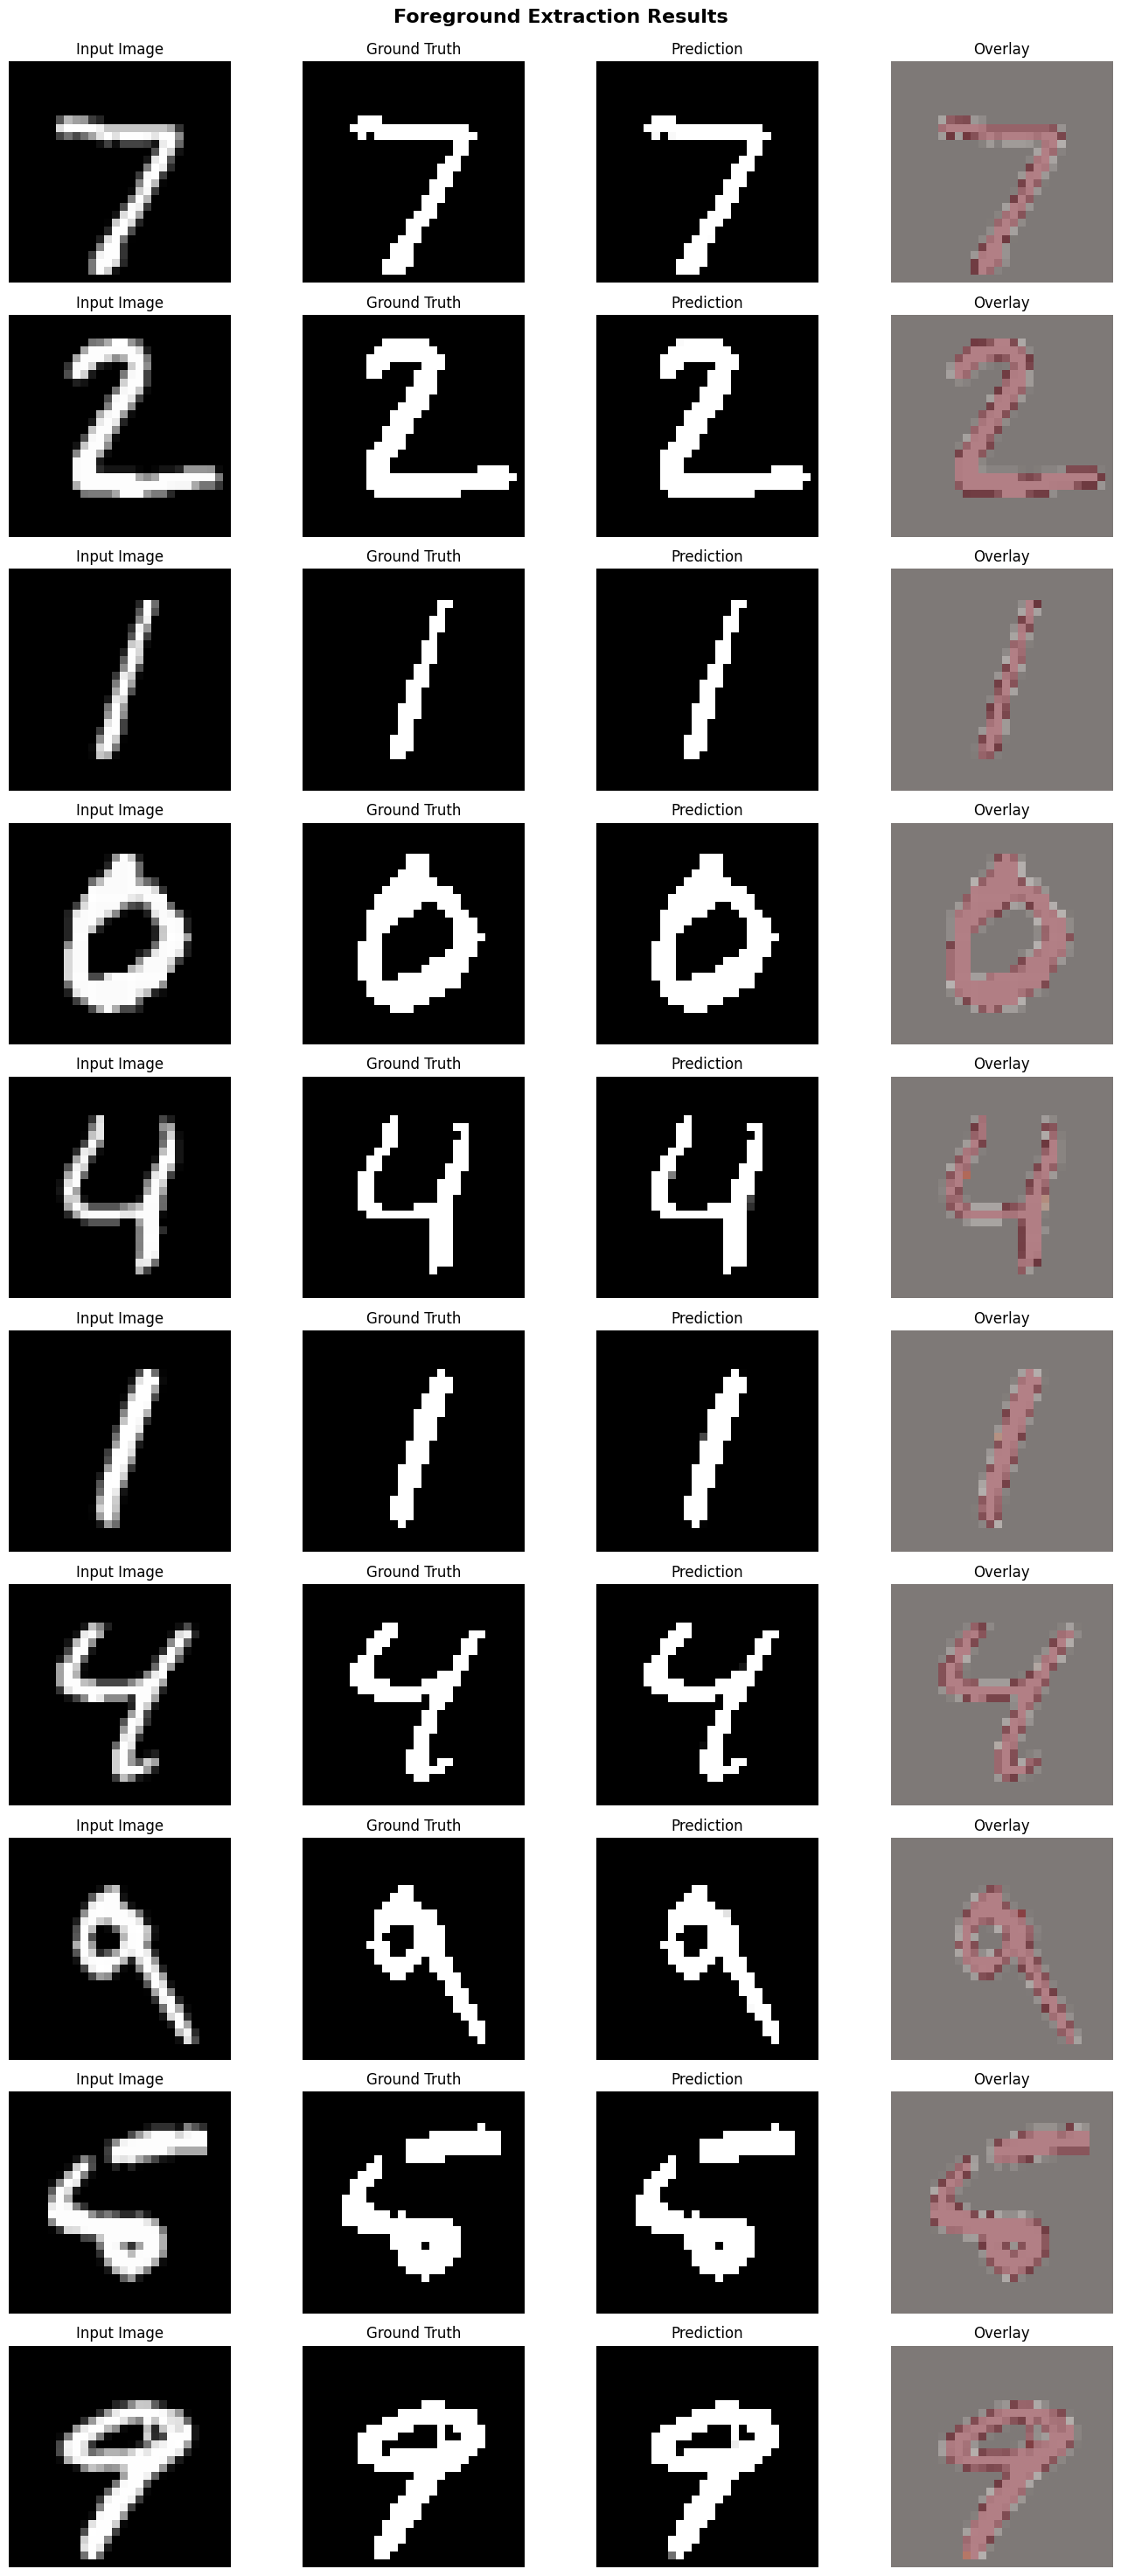


Predictions saved as 'prediction_results_foreground_extraction.png'

FINAL RESULTS - FOREGROUND EXTRACTION
Best Validation IoU: 0.9961 (99.61%)
Test IoU:            0.9963 (99.63%)

Model saved as: best_foreground_model.pth
Training history: training_history_foreground_extraction.png
Predictions: prediction_results_foreground_extraction.png


In [26]:
# Load best model
print("\nLoading best model...")
model.load_state_dict(torch.load('best_foreground_model.pth'))

# Evaluate on test set
test_iou, predictions, targets = evaluate_model(model, test_loader, device)

# Visualize predictions
print("Visualizing predictions...\n")
visualize_predictions(model, test_loader, device, num_samples = 10)

# Print final summary
print("\n" + "="*70)
print("FINAL RESULTS - FOREGROUND EXTRACTION")
print("="*70)
print(f"Best Validation IoU: {max(history['val_iou']):.4f} ({max(history['val_iou'])*100:.2f}%)")
print(f"Test IoU:            {test_iou:.4f} ({test_iou*100:.2f}%)")
print("="*70)
print("\nModel saved as: best_foreground_model.pth")
print("Training history: training_history_foreground_extraction.png")
print("Predictions: prediction_results_foreground_extraction.png")
print("="*70)

# **Q3. Classification with Circlization**

## **Train a deep learning network from scratch to perform classification with circlization on the dataset created in Q1(b). Report your test performance using the IoU metric.**

### **Data Loader for Circular Classification Dataset**

In [27]:
class CircularClassificationDataset(Dataset):
    """ Dataset class for classification with circular localization """

    def __init__(self, base_dir, split='train', transform=None):
        self.base_dir = base_dir
        self.split = split
        self.transform = transform
        self.samples = []

        # Load all samples from class folders
        for class_id in range(10):
            class_dir = os.path.join(base_dir, split, f'class_{class_id}')
            image_dir = os.path.join(class_dir, 'images')
            mask_dir = os.path.join(class_dir, 'masks')

            if os.path.exists(image_dir):
                image_files = sorted(os.listdir(image_dir))
                for img_file in image_files:
                    self.samples.append({
                        'image_path': os.path.join(image_dir, img_file),
                        'mask_path': os.path.join(mask_dir, img_file),
                        'label': class_id
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image and mask
        image = Image.open(sample['image_path']).convert('L')
        mask = Image.open(sample['mask_path']).convert('L')
        label = sample['label']

        # Convert to numpy arrays
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
        mask = np.array(mask, dtype=np.float32) / 255.0    # Normalize to [0, 1]

        # Add channel dimension
        image = np.expand_dims(image, axis=0)  # (1, 28, 28)
        mask = np.expand_dims(mask, axis=0)    # (1, 28, 28)

        # Convert to torch tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        label = torch.tensor(label, dtype=torch.long)

        return image, mask, label

### **Network Architecture for Classification with Circlization**

In [28]:
class CircularClassificationNet(nn.Module):
    """
    Network for classification with circular localization.
    Outputs both class prediction and circular mask.
    """

    def __init__(self, num_classes=10):
        super(CircularClassificationNet, self).__init__()

        # Shared Encoder
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # ========== Segmentation Branch (Decoder for circular mask) ==========
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0, output_padding=1)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Segmentation output
        self.seg_out = nn.Conv2d(64, 1, kernel_size=1)

        # ========== Classification Branch ==========
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def conv_block(self, in_channels, out_channels):
        """ Convolutional block """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Shared Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # ========== Segmentation Branch ==========
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        # Circular mask output
        mask = self.seg_out(dec1)
        mask = torch.sigmoid(mask)

        # ========== Classification Branch ==========
        class_features = self.global_pool(bottleneck)
        class_logits = self.classifier(class_features)

        return class_logits, mask

### **IoU Metric with Classification Constraint**

In [29]:
def calculate_classification_iou(pred_masks, target_masks, pred_classes, target_classes, threshold = 0.5):
    """
    Calculate IoU metric for classification with circlization.
    If classification is wrong, IoU = 0 for that sample.

    Args:
        pred_masks: Predicted masks (B, 1, H, W)
        target_masks: Ground truth masks (B, 1, H, W)
        pred_classes: Predicted class labels (B,)
        target_classes: Ground truth class labels (B,)
        threshold: Threshold to binarize predictions

    Returns:
        Mean IoU score
    """
    # Binarize masks
    pred_masks = (pred_masks > threshold).float()
    target_masks = (target_masks > threshold).float()

    # Calculate IoU for each sample
    batch_size = pred_masks.shape[0]
    iou_scores = []

    for i in range(batch_size):
        # Check if classification is correct
        if pred_classes[i] == target_classes[i]:
            # Calculate IoU
            intersection = (pred_masks[i] * target_masks[i]).sum()
            union = pred_masks[i].sum() + target_masks[i].sum() - intersection
            iou = (intersection + 1e-7) / (union + 1e-7)
            iou_scores.append(iou.item())
        else:
            # Classification wrong, IoU = 0
            iou_scores.append(0.0)

    return np.mean(iou_scores)

### **Training Function for Classification with Circlization**

In [30]:
def train_circular_model(model, train_loader, val_loader, criterion_seg, criterion_cls,
                        optimizer, num_epochs, device):
    """ Train the classification with circlization model """

    print("\n" + "="*70)
    print("TRAINING CLASSIFICATION WITH CIRCLIZATION MODEL")
    print("="*70)

    history = {
        'train_loss': [],
        'train_cls_acc': [],
        'train_iou': [],
        'val_loss': [],
        'val_cls_acc': [],
        'val_iou': []
    }

    best_val_iou = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()

        # ========== Training Phase ==========
        model.train()
        train_loss = 0.0
        train_cls_correct = 0
        train_total = 0
        train_iou = 0.0

        for images, masks, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            class_logits, pred_masks = model(images)

            # Calculate losses
            seg_loss = criterion_seg(pred_masks, masks)
            cls_loss = criterion_cls(class_logits, labels)
            loss = seg_loss + cls_loss  # Combined loss

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item()

            # Classification accuracy
            _, predicted = torch.max(class_logits, 1)
            train_total += labels.size(0)
            train_cls_correct += (predicted == labels).sum().item()

            # IoU (with classification constraint)
            train_iou += calculate_classification_iou(pred_masks, masks, predicted, labels)

        train_loss /= len(train_loader)
        train_cls_acc = train_cls_correct / train_total
        train_iou /= len(train_loader)

        # ========== Validation Phase ==========
        model.eval()
        val_loss = 0.0
        val_cls_correct = 0
        val_total = 0
        val_iou = 0.0

        with torch.no_grad():
            for images, masks, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  '):
                images = images.to(device)
                masks = masks.to(device)
                labels = labels.to(device)

                # Forward pass
                class_logits, pred_masks = model(images)

                # Calculate losses
                seg_loss = criterion_seg(pred_masks, masks)
                cls_loss = criterion_cls(class_logits, labels)
                loss = seg_loss + cls_loss

                # Calculate metrics
                val_loss += loss.item()

                # Classification accuracy
                _, predicted = torch.max(class_logits, 1)
                val_total += labels.size(0)
                val_cls_correct += (predicted == labels).sum().item()

                # IoU (with classification constraint)
                val_iou += calculate_classification_iou(pred_masks, masks, predicted, labels)

        val_loss /= len(val_loader)
        val_cls_acc = val_cls_correct / val_total
        val_iou /= len(val_loader)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_cls_acc'].append(train_cls_acc)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_cls_acc'].append(val_cls_acc)
        history['val_iou'].append(val_iou)

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_cls_acc:.4f} | Train IoU: {train_iou:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_cls_acc:.4f} | Val IoU:   {val_iou:.4f}")

        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_circular_classification_model.pth')
            print(f"Best model saved (Val IoU: {val_iou:.4f})")

        print("-" * 70)

    return history

### **Evaluation Function**

In [31]:
def evaluate_circular_model(model, test_loader, device):
    """ Evaluate classification with circlization model on test set """

    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70)

    model.eval()
    test_cls_correct = 0
    test_total = 0
    test_iou = 0.0

    # For confusion analysis
    class_correct = [0] * 10
    class_total = [0] * 10
    class_iou = [[] for _ in range(10)]

    with torch.no_grad():
        for images, masks, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # Forward pass
            class_logits, pred_masks = model(images)

            # Get predictions
            _, predicted = torch.max(class_logits, 1)

            # Classification accuracy
            test_total += labels.size(0)
            test_cls_correct += (predicted == labels).sum().item()

            # IoU (with classification constraint)
            batch_iou = calculate_classification_iou(pred_masks, masks, predicted, labels)
            test_iou += batch_iou

            # Per-class statistics
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
                    # Calculate IoU for this sample
                    pred_mask = (pred_masks[i] > 0.5).float()
                    target_mask = (masks[i] > 0.5).float()
                    intersection = (pred_mask * target_mask).sum()
                    union = pred_mask.sum() + target_mask.sum() - intersection
                    iou = (intersection + 1e-7) / (union + 1e-7)
                    class_iou[label].append(iou.item())

    test_cls_acc = test_cls_correct / test_total
    test_iou /= len(test_loader)

    print(f"\nOverall Test Accuracy: {test_cls_acc:.4f} ({test_cls_acc*100:.2f}%)")
    print(f"Overall Test IoU:      {test_iou:.4f} ({test_iou*100:.2f}%)")

    print("\n" + "-"*70)
    print("Per-Class Performance:")
    print(f"{'Class':<8} {'Accuracy':<12} {'Avg IoU':<12} {'Samples':<10}")
    print("-" * 70)
    for i in range(10):
        acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        avg_iou = np.mean(class_iou[i]) if len(class_iou[i]) > 0 else 0.0
        print(f"{i:<8} {acc:<12.4f} {avg_iou:<12.4f} {class_total[i]:<10}")

    print("="*70)

    return test_cls_acc, test_iou

### **Visualization Functions**

In [32]:
def plot_circular_training_history(history):
    """ Plot training history for classification with circlization """

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker = 'o')
    axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker = 's')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].set_xticks(range(1, len(history['train_loss']) + 1, 1))
    axes[0].set_ylim(bottom=None)
    axes[0].grid(True)

    # Accuracy plot
    axes[1].plot(epochs, history['train_cls_acc'], label='Train Accuracy', marker = 'o')
    axes[1].plot(epochs, history['val_cls_acc'], label='Val Accuracy', marker = 's')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Classification Accuracy')
    axes[1].legend()
    axes[1].set_xticks(range(1, len(history['train_cls_acc']) + 1, 1))
    axes[1].set_ylim(bottom=None)
    axes[1].grid(True)

    # IoU plot
    axes[2].plot(epochs, history['train_iou'], label='Train IoU', marker='o')
    axes[2].plot(epochs, history['val_iou'], label='Val IoU', marker='s')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU')
    axes[2].set_title('Circular Localization IoU')
    axes[2].legend()
    axes[2].set_xticks(range(1, len(history['train_iou']) + 1, 1))
    axes[2].set_ylim(bottom=None)
    axes[2].grid(True)

    plt.suptitle('Training History - Classification with Circlization', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    plt.savefig('training_history_circular_classification.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

    print("\nTraining history saved as 'training_history_circular_classification.png'")

In [33]:
def visualize_circular_predictions(model, test_loader, device, num_samples = 10):
    """ Visualize classification with circlization predictions """

    model.eval()

    # Get a batch of test data
    images, masks, labels = next(iter(test_loader))
    images_gpu = images.to(device)

    with torch.no_grad():
        class_logits, pred_masks = model(images_gpu)
        _, predicted_classes = torch.max(class_logits, 1)

    # Move to CPU for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    pred_masks = pred_masks.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted_classes = predicted_classes.cpu().numpy()

    # Plot predictions
    fig, axes = plt.subplots(num_samples, 5, figsize = (18, num_samples*3))

    for i in range(min(num_samples, len(images))):
        true_label = labels[i]
        pred_label = predicted_classes[i]
        correct = (true_label == pred_label)

        # Original image
        axes[i, 0].imshow(images[i, 0], cmap = 'gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0], cmap = 'gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(pred_masks[i, 0], cmap = 'gray')
        axes[i, 2].set_title('Predicted')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(images[i, 0], cmap = 'gray')
        axes[i, 3].imshow(pred_masks[i, 0], cmap = 'Reds', alpha = 0.5)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

        # Classification result
        axes[i, 4].text(0.5, 0.6, f'True: {true_label}',
                       ha = 'center', va = 'center', fontsize = 14, fontweight = 'bold')
        axes[i, 4].text(0.5, 0.4, f'Pred: {pred_label}',
                       ha = 'center', va = 'center', fontsize = 14,
                       color = 'green' if correct else 'red', fontweight = 'bold')

        # Calculate IoU
        if correct:
            pred_binary = (pred_masks[i, 0] > 0.5).astype(np.float32)
            mask_binary = (masks[i, 0] > 0.5).astype(np.float32)
            intersection = (pred_binary * mask_binary).sum()
            union = pred_binary.sum() + mask_binary.sum() - intersection
            iou = intersection / (union + 1e-7)
        else:
            iou = 0.0

        axes[i, 4].text(0.5, 0.2, f'IoU: {iou:.3f}',
                       ha='center', va='center', fontsize = 12)
        axes[i, 4].set_xlim(0, 1)
        axes[i, 4].set_ylim(0, 1)
        axes[i, 4].axis('off')

        # Add status indicator
        #status = '✓' if correct else '✗'
        #color = 'green' if correct else 'red'
        #axes[i, 0].set_ylabel(f'{status}', fontsize = 20, fontweight = 'bold', color = color)

    plt.suptitle('Classification with Circlization Results', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.96)
    plt.savefig('prediction_results_circular_classification.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

    print("\nPredictions saved as 'prediction_results_circular_classification.png'")

### **Main Training Pipeline for Classification with circlization**


Q3: CLASSIFICATION WITH CIRCLIZATION

Using device: cuda

Preparing circular classification dataset...
Training samples: 54000
Validation samples: 6000
Test samples: 10000

Initializing Classification with Circlization model...
Total parameters: 31,701,067
Trainable parameters: 31,701,067

TRAINING CLASSIFICATION WITH CIRCLIZATION MODEL


Epoch 1/20 [Val]  : 100%|██████████| 94/94 [00:06<00:00, 15.39it/s]



Epoch 1/20 - Time: 93.83s
  Train Loss: 0.2855 | Train Acc: 0.9544 | Train IoU: 0.8525
  Val Loss:   0.1733 | Val Acc:   0.9800 | Val IoU:   0.8822
Best model saved (Val IoU: 0.8822)
----------------------------------------------------------------------


Epoch 2/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.76it/s]



Epoch 2/20 - Time: 89.10s
  Train Loss: 0.1674 | Train Acc: 0.9809 | Train IoU: 0.8937
  Val Loss:   0.1235 | Val Acc:   0.9877 | Val IoU:   0.9053
Best model saved (Val IoU: 0.9053)
----------------------------------------------------------------------


Epoch 3/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.73it/s]



Epoch 3/20 - Time: 89.39s
  Train Loss: 0.1507 | Train Acc: 0.9839 | Train IoU: 0.9028
  Val Loss:   0.1147 | Val Acc:   0.9913 | Val IoU:   0.9090
Best model saved (Val IoU: 0.9090)
----------------------------------------------------------------------


Epoch 4/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 21.17it/s]



Epoch 4/20 - Time: 89.70s
  Train Loss: 0.1312 | Train Acc: 0.9875 | Train IoU: 0.9115
  Val Loss:   0.1253 | Val Acc:   0.9902 | Val IoU:   0.9153
Best model saved (Val IoU: 0.9153)
----------------------------------------------------------------------


Epoch 5/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 25.06it/s]



Epoch 5/20 - Time: 88.93s
  Train Loss: 0.1269 | Train Acc: 0.9877 | Train IoU: 0.9163
  Val Loss:   0.1067 | Val Acc:   0.9905 | Val IoU:   0.9197
Best model saved (Val IoU: 0.9197)
----------------------------------------------------------------------


Epoch 6/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 25.16it/s]



Epoch 6/20 - Time: 88.92s
  Train Loss: 0.1156 | Train Acc: 0.9892 | Train IoU: 0.9214
  Val Loss:   0.0948 | Val Acc:   0.9935 | Val IoU:   0.9215
Best model saved (Val IoU: 0.9215)
----------------------------------------------------------------------


Epoch 7/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 23.75it/s]



Epoch 7/20 - Time: 88.88s
  Train Loss: 0.1044 | Train Acc: 0.9908 | Train IoU: 0.9260
  Val Loss:   0.0932 | Val Acc:   0.9925 | Val IoU:   0.9289
Best model saved (Val IoU: 0.9289)
----------------------------------------------------------------------


Epoch 8/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 20.80it/s]



Epoch 8/20 - Time: 90.03s
  Train Loss: 0.1016 | Train Acc: 0.9912 | Train IoU: 0.9287
  Val Loss:   0.1049 | Val Acc:   0.9898 | Val IoU:   0.9283
----------------------------------------------------------------------


Epoch 9/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.85it/s]



Epoch 9/20 - Time: 89.02s
  Train Loss: 0.0961 | Train Acc: 0.9916 | Train IoU: 0.9315
  Val Loss:   0.0927 | Val Acc:   0.9930 | Val IoU:   0.9304
Best model saved (Val IoU: 0.9304)
----------------------------------------------------------------------


Epoch 10/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 25.06it/s]



Epoch 10/20 - Time: 89.11s
  Train Loss: 0.0930 | Train Acc: 0.9925 | Train IoU: 0.9340
  Val Loss:   0.0931 | Val Acc:   0.9922 | Val IoU:   0.9292
----------------------------------------------------------------------


Epoch 11/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 23.09it/s]



Epoch 11/20 - Time: 89.09s
  Train Loss: 0.0844 | Train Acc: 0.9941 | Train IoU: 0.9374
  Val Loss:   0.0942 | Val Acc:   0.9922 | Val IoU:   0.9345
Best model saved (Val IoU: 0.9345)
----------------------------------------------------------------------


Epoch 12/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 21.42it/s]



Epoch 12/20 - Time: 89.50s
  Train Loss: 0.0791 | Train Acc: 0.9941 | Train IoU: 0.9394
  Val Loss:   0.0887 | Val Acc:   0.9947 | Val IoU:   0.9374
Best model saved (Val IoU: 0.9374)
----------------------------------------------------------------------


Epoch 13/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.86it/s]



Epoch 13/20 - Time: 89.01s
  Train Loss: 0.0827 | Train Acc: 0.9941 | Train IoU: 0.9401
  Val Loss:   0.0876 | Val Acc:   0.9925 | Val IoU:   0.9383
Best model saved (Val IoU: 0.9383)
----------------------------------------------------------------------


Epoch 14/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.42it/s]



Epoch 14/20 - Time: 89.47s
  Train Loss: 0.0741 | Train Acc: 0.9951 | Train IoU: 0.9432
  Val Loss:   0.1096 | Val Acc:   0.9903 | Val IoU:   0.9340
----------------------------------------------------------------------


Epoch 15/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 21.48it/s]



Epoch 15/20 - Time: 90.33s
  Train Loss: 0.0727 | Train Acc: 0.9949 | Train IoU: 0.9436
  Val Loss:   0.0738 | Val Acc:   0.9953 | Val IoU:   0.9415
Best model saved (Val IoU: 0.9415)
----------------------------------------------------------------------


Epoch 16/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 22.42it/s]



Epoch 16/20 - Time: 89.52s
  Train Loss: 0.0693 | Train Acc: 0.9957 | Train IoU: 0.9462
  Val Loss:   0.0823 | Val Acc:   0.9938 | Val IoU:   0.9401
----------------------------------------------------------------------


Epoch 17/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.72it/s]



Epoch 17/20 - Time: 89.05s
  Train Loss: 0.0680 | Train Acc: 0.9957 | Train IoU: 0.9473
  Val Loss:   0.0788 | Val Acc:   0.9953 | Val IoU:   0.9430
Best model saved (Val IoU: 0.9430)
----------------------------------------------------------------------


Epoch 18/20 [Val]  : 100%|██████████| 94/94 [00:03<00:00, 24.74it/s]



Epoch 18/20 - Time: 89.05s
  Train Loss: 0.0679 | Train Acc: 0.9954 | Train IoU: 0.9481
  Val Loss:   0.0783 | Val Acc:   0.9948 | Val IoU:   0.9421
----------------------------------------------------------------------


Epoch 19/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 20.97it/s]



Epoch 19/20 - Time: 89.58s
  Train Loss: 0.0647 | Train Acc: 0.9958 | Train IoU: 0.9496
  Val Loss:   0.0814 | Val Acc:   0.9950 | Val IoU:   0.9432
Best model saved (Val IoU: 0.9432)
----------------------------------------------------------------------


Epoch 20/20 [Val]  : 100%|██████████| 94/94 [00:04<00:00, 23.41it/s]



Epoch 20/20 - Time: 89.16s
  Train Loss: 0.0591 | Train Acc: 0.9969 | Train IoU: 0.9521
  Val Loss:   0.0741 | Val Acc:   0.9957 | Val IoU:   0.9440
Best model saved (Val IoU: 0.9440)
----------------------------------------------------------------------

Plotting training history...



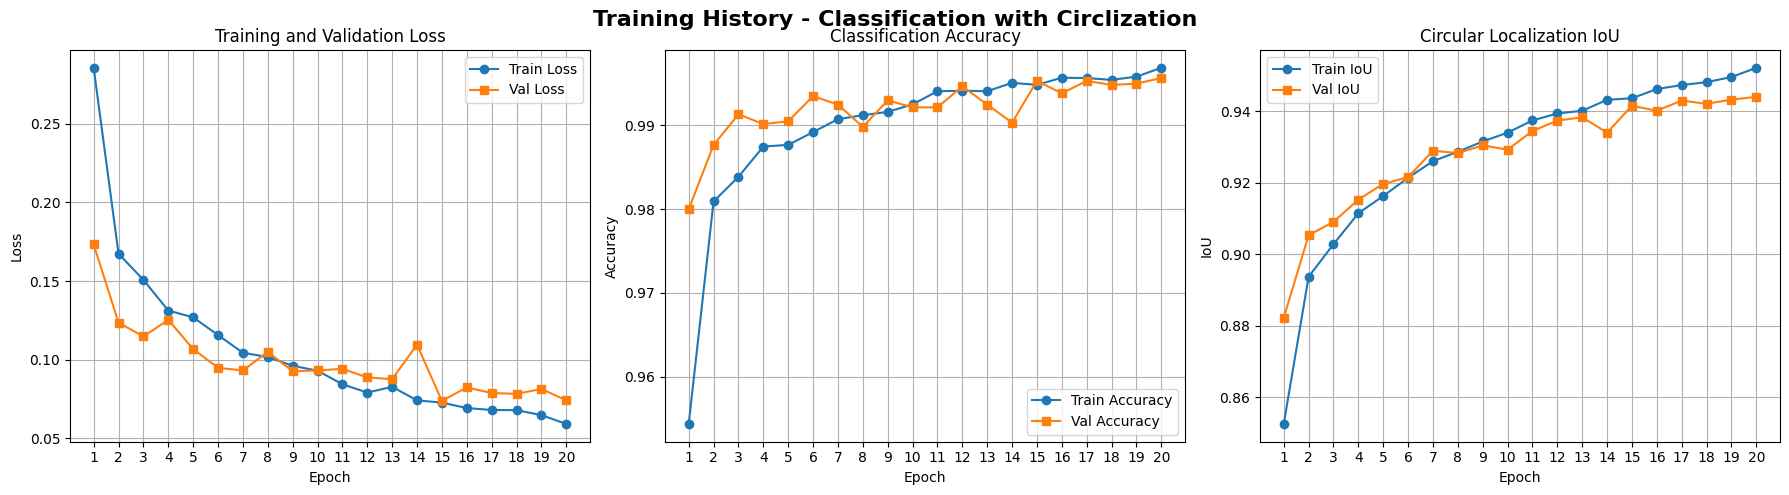


Training history saved as 'training_history_circular_classification.png'


In [34]:
print("\n" + "="*70)
print("Q3: CLASSIFICATION WITH CIRCLIZATION")
print("="*70)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Hyperparameters
BATCH_SIZE_Q3 = 64
NUM_EPOCHS_Q3 = 20
LEARNING_RATE_Q3 = 0.001
VAL_SPLIT_Q3 = 0.1

# Prepare dataset
print("\nPreparing circular classification dataset...")
base_dir = 'circular_classification'

# Create full dataset
train_dataset_full = CircularClassificationDataset(base_dir, split='train')
test_dataset_q3 = CircularClassificationDataset(base_dir, split='test')

# Split train into train and validation
train_size = int((1 - VAL_SPLIT_Q3) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset_q3, val_dataset_q3 = torch.utils.data.random_split(
    train_dataset_full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset_q3)}")
print(f"Validation samples: {len(val_dataset_q3)}")
print(f"Test samples: {len(test_dataset_q3)}")

# Create data loaders
train_loader_q3 = DataLoader(train_dataset_q3, batch_size=BATCH_SIZE_Q3, shuffle=True, num_workers=2)
val_loader_q3 = DataLoader(val_dataset_q3, batch_size=BATCH_SIZE_Q3, shuffle=False, num_workers=2)
test_loader_q3 = DataLoader(test_dataset_q3, batch_size=BATCH_SIZE_Q3, shuffle=False, num_workers=2)

# Initialize model
print("\nInitializing Classification with Circlization model...")
model_q3 = CircularClassificationNet(num_classes=10).to(device)

# Count parameters
total_params_q3 = sum(p.numel() for p in model_q3.parameters())
trainable_params_q3 = sum(p.numel() for p in model_q3.parameters() if p.requires_grad)
print(f"Total parameters: {total_params_q3:,}")
print(f"Trainable parameters: {trainable_params_q3:,}")

# Loss functions and optimizer
criterion_seg_q3 = nn.BCELoss()  # For circular mask
criterion_cls_q3 = nn.CrossEntropyLoss()  # For classification
optimizer_q3 = optim.Adam(model_q3.parameters(), lr=LEARNING_RATE_Q3)

# Train model
history_q3 = train_circular_model(
    model_q3, train_loader_q3, val_loader_q3,
    criterion_seg_q3, criterion_cls_q3, optimizer_q3,
    NUM_EPOCHS_Q3, device
)

# Plot training history
print("\nPlotting training history...\n")
plot_circular_training_history(history_q3)

# **Evaluate and Visualize**


Loading best model...

EVALUATING ON TEST SET


Testing: 100%|██████████| 157/157 [00:12<00:00, 12.92it/s]


Overall Test Accuracy: 0.9946 (99.46%)
Overall Test IoU:      0.9439 (94.39%)

----------------------------------------------------------------------
Per-Class Performance:
Class    Accuracy     Avg IoU      Samples   
----------------------------------------------------------------------
0        1.0000       0.9426       980       
1        0.9974       0.9776       1135      
2        0.9971       0.9341       1032      
3        0.9950       0.9453       1010      
4        0.9980       0.9450       982       
5        0.9933       0.9410       892       
6        0.9906       0.9527       958       
7        0.9951       0.9439       1028      
8        0.9959       0.9455       974       
9        0.9832       0.9581       1009      

Visualizing predictions...



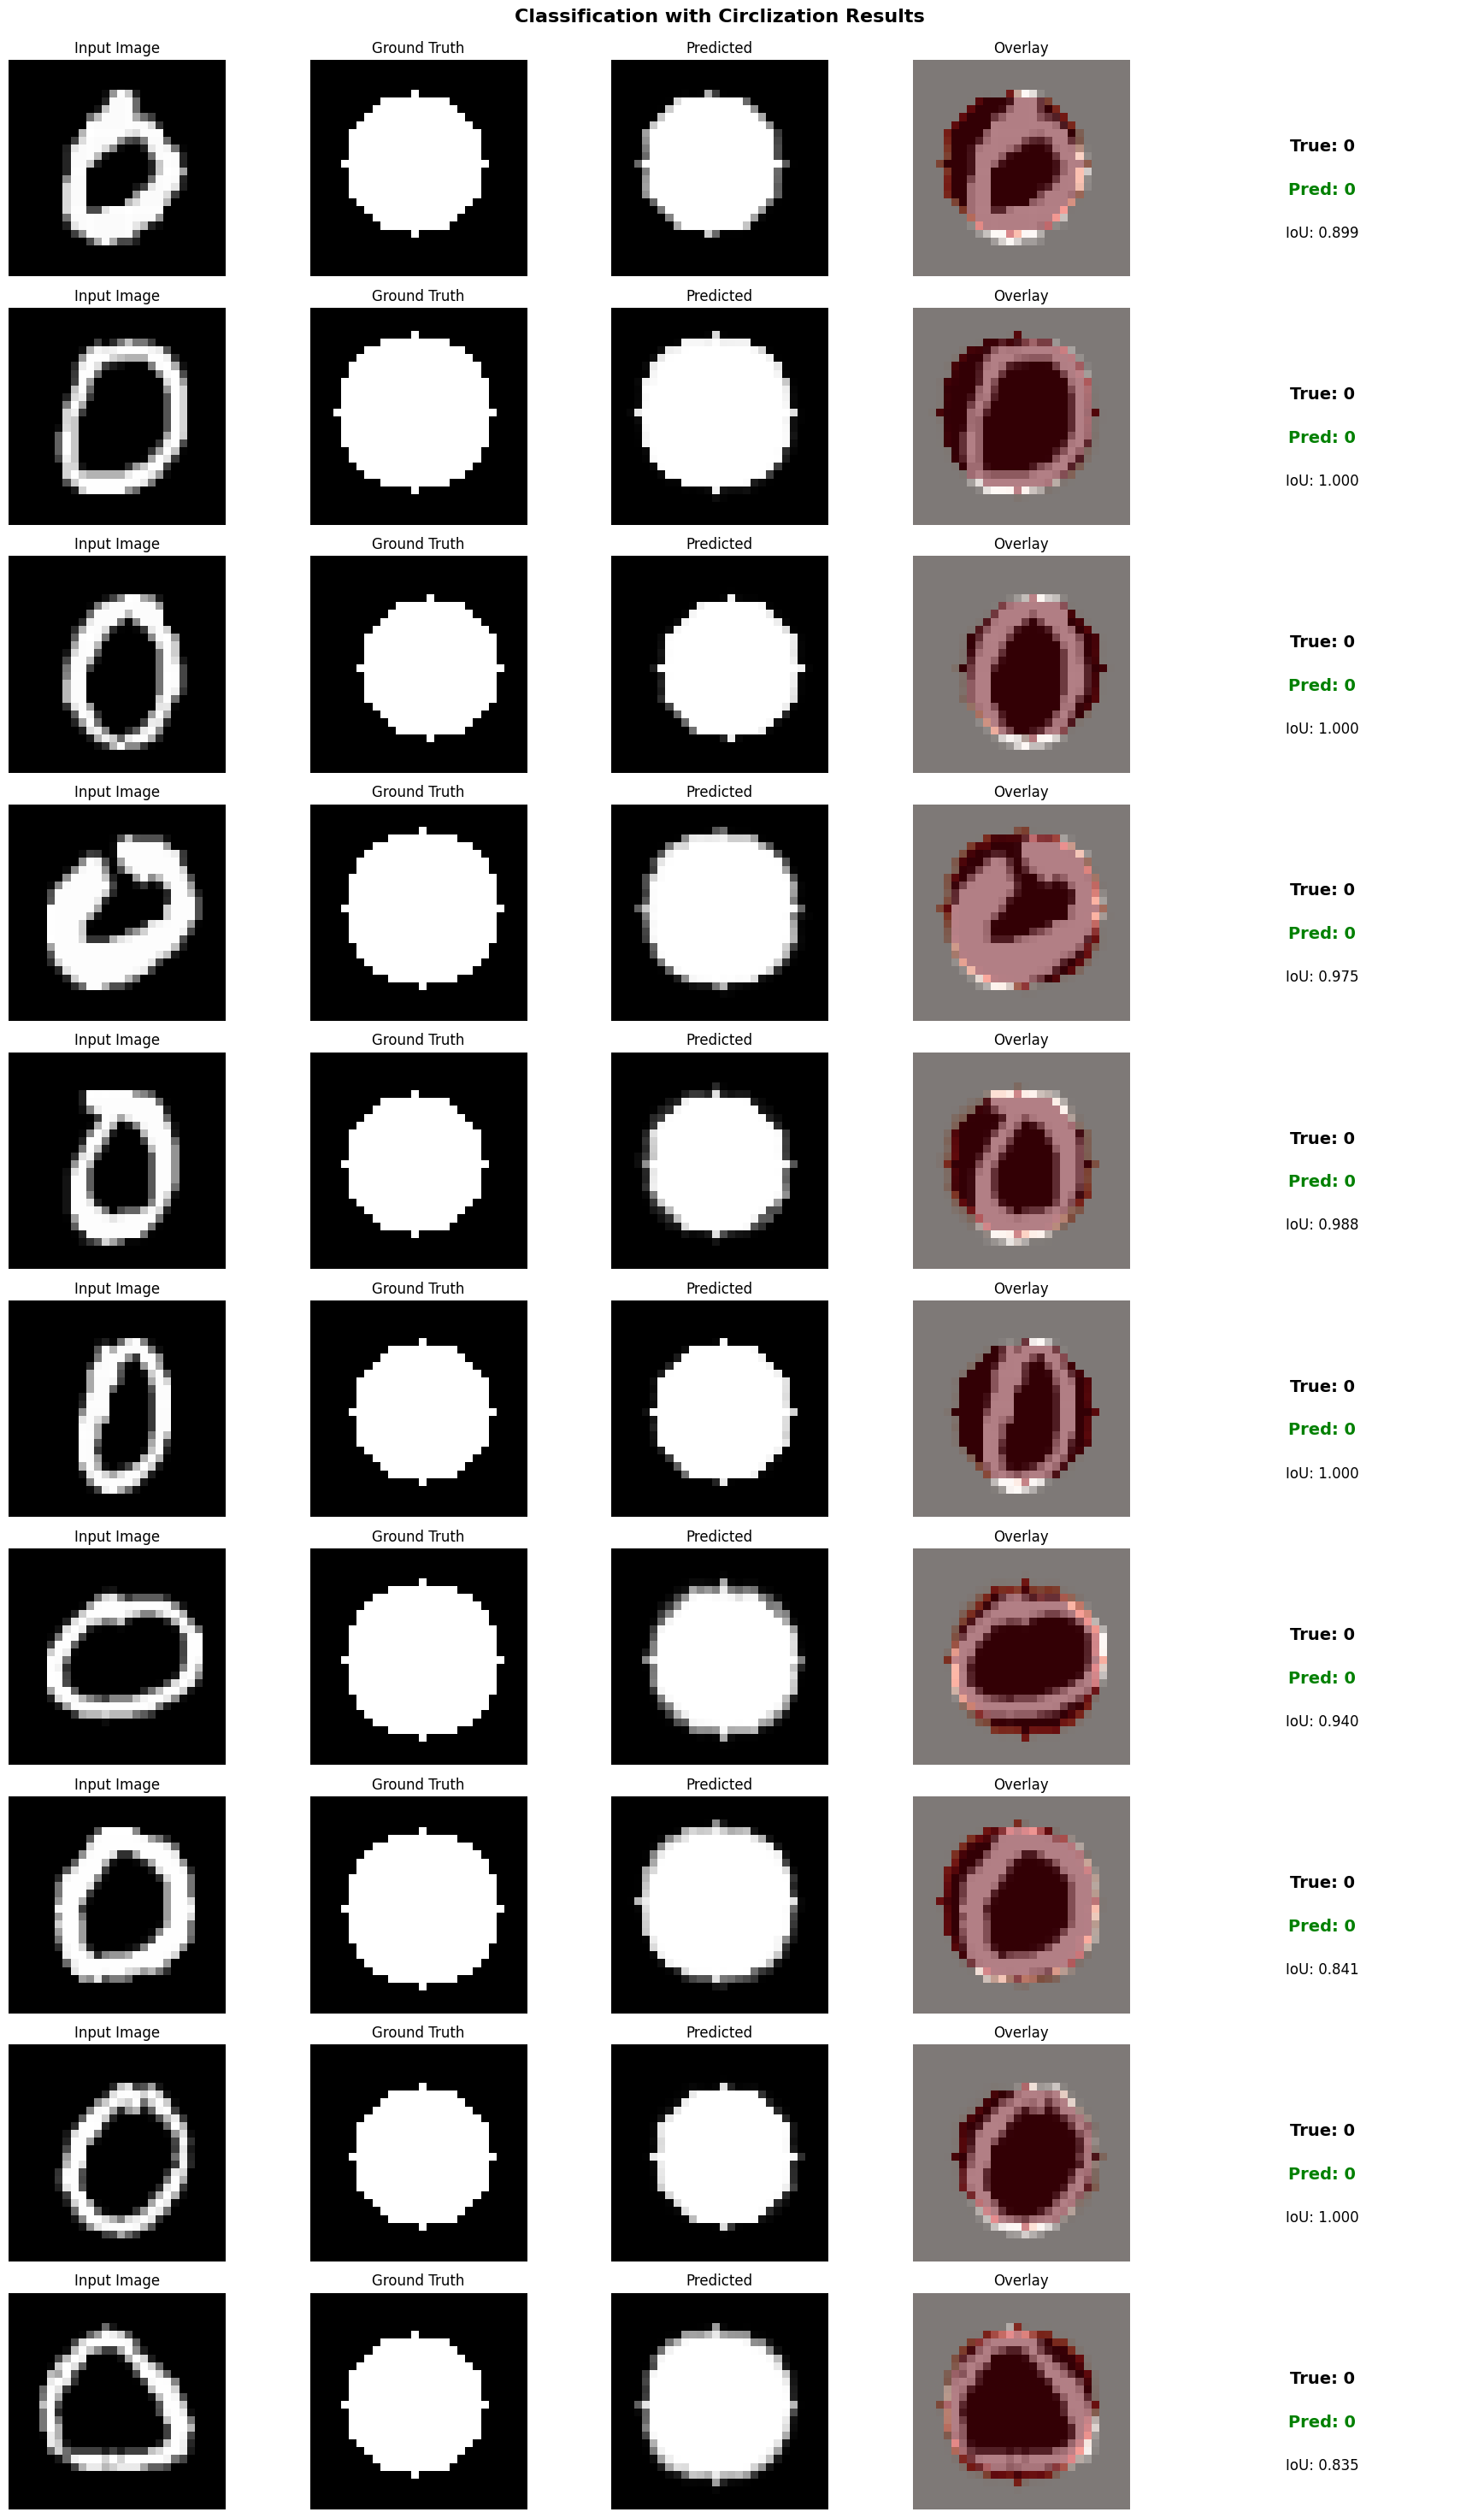


Predictions saved as 'prediction_results_circular_classification.png'

FINAL RESULTS - CLASSIFICATION WITH CIRCLIZATION
Best Validation IoU: 0.9440 (94.40%)
Best Validation Acc: 0.9957 (99.57%)

Test Accuracy:       0.9946 (99.46%)
Test IoU:            0.9439 (94.39%)

Saved files:
  - Model: best_circular_classification_model.pth
  - Training history: training_history_circular_classification.png
  - Predictions: prediction_results_circular_classification.png


In [35]:
# Load best model
print("\nLoading best model...")
model_q3.load_state_dict(torch.load('best_circular_classification_model.pth'))

# Evaluate on test set
test_acc_q3, test_iou_q3 = evaluate_circular_model(model_q3, test_loader_q3, device)

# Visualize predictions
print("\nVisualizing predictions...\n")
visualize_circular_predictions(model_q3, test_loader_q3, device, num_samples=10)

# Print final summary
print("\n" + "="*70)
print("FINAL RESULTS - CLASSIFICATION WITH CIRCLIZATION")
print("="*70)
print(f"Best Validation IoU: {max(history_q3['val_iou']):.4f} ({max(history_q3['val_iou'])*100:.2f}%)")
print(f"Best Validation Acc: {max(history_q3['val_cls_acc']):.4f} ({max(history_q3['val_cls_acc'])*100:.2f}%)")
print(f"\nTest Accuracy:       {test_acc_q3:.4f} ({test_acc_q3*100:.2f}%)")
print(f"Test IoU:            {test_iou_q3:.4f} ({test_iou_q3*100:.2f}%)")
print("="*70)
print("\nSaved files:")
print("  - Model: best_circular_classification_model.pth")
print("  - Training history: training_history_circular_classification.png")
print("  - Predictions: prediction_results_circular_classification.png")
print("="*70)

# **Q4. Semantic Segmentation**

## **Train a deep learning network from scratch to perform semantic segmentation on the dataset created in Q1(c). Report your test performance using the Dice Coefficient.**

### **Data Loader for Semantic Segmentation Dataset**

In [36]:
class SemanticSegmentationDataset(Dataset):
    """ Dataset class for semantic segmentation """

    def __init__(self, image_dir, mask_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        img_name = self.image_files[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert('L')
        mask = Image.open(os.path.join(self.mask_dir, img_name))

        # Convert to numpy arrays
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
        mask = np.array(mask, dtype=np.int64)  # Keep as class indices (0-10)

        # Add channel dimension to image
        image = np.expand_dims(image, axis=0)  # (1, 56, 56)
        # Mask stays as (56, 56) for CrossEntropyLoss

        # Convert to torch tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        return image, mask

### **U-Net Architecture for Multi-Class Semantic Segmentation**

In [37]:
class SemanticSegmentationUNet(nn.Module):
    """ U-Net for multi-class semantic segmentation (11 classes) """

    def __init__(self, in_channels=1, num_classes=11):
        super(SemanticSegmentationUNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, output_padding=1)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer (num_classes channels for multi-class segmentation)
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """ Convolutional block """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)

        # Output (B, num_classes, H, W)
        out = self.out(dec1)

        return out

### **Dice Coefficient Metric**

In [38]:
def calculate_dice_coefficient(pred, target, num_classes = 11, smooth = 1e-7):
    """
    Calculate Dice Coefficient for multi-class segmentation

    Args:
        pred: Predicted logits (B, num_classes, H, W)
        target: Ground truth class indices (B, H, W)
        num_classes: Number of classes
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Mean Dice Coefficient across all classes
    """
    # Get predicted classes
    pred_classes = torch.argmax(pred, dim=1)  # (B, H, W)

    dice_scores = []

    # Calculate Dice for each class
    for class_id in range(num_classes):
        # Create binary masks for this class
        pred_mask = (pred_classes == class_id).float()
        target_mask = (target == class_id).float()

        # Calculate intersection and union
        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        # Dice coefficient: 2 * intersection / (sum of both)
        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    # Return mean Dice across all classes
    return np.mean(dice_scores)

def calculate_per_class_dice(pred, target, num_classes=11, smooth=1e-7):
    """
    Calculate Dice Coefficient for each class separately

    Returns:
        List of Dice scores for each class
    """
    pred_classes = torch.argmax(pred, dim=1)

    dice_scores = []

    for class_id in range(num_classes):
        pred_mask = (pred_classes == class_id).float()
        target_mask = (target == class_id).float()

        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return dice_scores

### **Training Function for Semantic Segmentation**

In [39]:
def train_semantic_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """ Train the semantic segmentation model """

    print("\n" + "="*70)
    print("TRAINING SEMANTIC SEGMENTATION MODEL")
    print("="*70)

    history = {
        'train_loss': [],
        'train_dice': [],
        'val_loss': [],
        'val_dice': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()

        # ========== Training Phase ==========
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate metrics
            train_loss += loss.item()
            train_dice += calculate_dice_coefficient(outputs, masks)

        train_loss /= len(train_loader)
        train_dice /= len(train_loader)

        # ========== Validation Phase ==========
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  '):
                images = images.to(device)
                masks = masks.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)

                # Calculate metrics
                val_loss += loss.item()
                val_dice += calculate_dice_coefficient(outputs, masks)

        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Dice:   {val_dice:.4f}")

        # Save best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_semantic_segmentation_model.pth')
            print(f"Best model saved (Val Dice: {val_dice:.4f})")

        print("-" * 70)

    return history

### **Evaluation Function**

In [40]:
def evaluate_semantic_model(model, test_loader, device, num_classes = 11):
    """ Evaluate semantic segmentation model on test set """

    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70)

    model.eval()
    test_dice = 0.0
    class_dice_scores = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate overall Dice
            test_dice += calculate_dice_coefficient(outputs, masks)

            # Calculate per-class Dice
            per_class_dice = calculate_per_class_dice(outputs, masks)
            for class_id in range(num_classes):
                class_dice_scores[class_id].append(per_class_dice[class_id])

    test_dice /= len(test_loader)

    print(f"\nOverall Test Dice Coefficient: {test_dice:.4f} ({test_dice*100:.2f}%)")

    print("\n" + "-"*70)
    print("Per-Class Dice Coefficient:")
    print(f"{'Class':<15} {'Dice Score':<15}")
    print("-" * 70)
    print(f"{'Background':<15} {np.mean(class_dice_scores[0]):.4f}")
    for i in range(1, num_classes):
        class_name = f"Digit {i-1}"
        print(f"{class_name:<15} {np.mean(class_dice_scores[i]):.4f}")

    print("="*70)

    return test_dice, class_dice_scores

### **Visualization Functions**

In [41]:
def plot_semantic_training_history(history):
    """ Plot training history for semantic segmentation """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(epochs, history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].set_xticks(range(1, len(history['train_loss']) + 1, 1))
    axes[0].set_ylim(bottom=None)
    axes[0].grid(True)

    # Dice plot
    axes[1].plot(epochs, history['train_dice'], label='Train Dice', marker='o')
    axes[1].plot(epochs, history['val_dice'], label='Val Dice', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Training and Validation Dice')
    axes[1].legend()
    axes[1].set_xticks(range(1, len(history['train_dice']) + 1, 1))
    axes[1].set_ylim(bottom=None)
    axes[1].grid(True)

    plt.suptitle('Training History - Semantic Segmentation', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig('training_history_semantic_segmentation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nTraining history saved as 'training_history_semantic_segmentation.png'")

def visualize_semantic_predictions(model, test_loader, device, num_samples=10):
    """ Visualize semantic segmentation predictions """

    model.eval()

    # Get a batch of test data
    images, masks = next(iter(test_loader))
    images_gpu = images.to(device)

    with torch.no_grad():
        outputs = model(images_gpu)
        predictions = torch.argmax(outputs, dim=1)

    # Move to CPU for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # Plot predictions
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples*3.5))

    for i in range(min(num_samples, len(images))):
        # Original image
        axes[i, 0].imshow(images[i, 0], cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth semantic mask
        axes[i, 1].imshow(masks[i], cmap='tab10', vmin=0, vmax=10)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted semantic mask
        axes[i, 2].imshow(predictions[i], cmap='tab10', vmin=0, vmax=10)
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

        # Overlay
        axes[i, 3].imshow(images[i, 0], cmap='gray')
        axes[i, 3].imshow(predictions[i], cmap='tab10', alpha=0.5, vmin=0, vmax=10)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

        # Calculate Dice for this sample
        dice_scores = []
        for class_id in range(11):
            pred_mask = (predictions[i] == class_id).astype(np.float32)
            target_mask = (masks[i] == class_id).astype(np.float32)
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum()
            dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
            dice_scores.append(dice)

        mean_dice = np.mean(dice_scores)
        axes[i, 0].set_ylabel(f'Dice: {mean_dice:.3f}', fontsize=12, fontweight='bold')

    plt.suptitle('Semantic Segmentation Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.96)
    plt.savefig('prediction_results_semantic_segmentation.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nPredictions saved as 'prediction_results_semantic_segmentation.png'")

### **Main Training Pipeline for Semantic Segmentation**


Q4: SEMANTIC SEGMENTATION

Using device: cuda

Preparing semantic segmentation dataset...
Training samples: 180000
Validation samples: 20000
Test samples: 50000

Initializing Semantic Segmentation U-Net...
Total parameters: 31,043,019
Trainable parameters: 31,043,019

TRAINING SEMANTIC SEGMENTATION MODEL


Epoch 1/4 [Val]  : 100%|██████████| 313/313 [00:22<00:00, 13.73it/s]



Epoch 1/4 - Time: 585.15s
  Train Loss: 0.0360 | Train Dice: 0.9693
  Val Loss:   0.0044 | Val Dice:   0.9933
Best model saved (Val Dice: 0.9933)
----------------------------------------------------------------------


Epoch 2/4 [Val]  : 100%|██████████| 313/313 [00:22<00:00, 13.83it/s]



Epoch 2/4 - Time: 585.09s
  Train Loss: 0.0037 | Train Dice: 0.9943
  Val Loss:   0.0054 | Val Dice:   0.9911
----------------------------------------------------------------------


Epoch 3/4 [Val]  : 100%|██████████| 313/313 [00:22<00:00, 13.87it/s]



Epoch 3/4 - Time: 584.56s
  Train Loss: 0.0028 | Train Dice: 0.9958
  Val Loss:   0.0022 | Val Dice:   0.9968
Best model saved (Val Dice: 0.9968)
----------------------------------------------------------------------


Epoch 4/4 [Val]  : 100%|██████████| 313/313 [00:23<00:00, 13.60it/s]



Epoch 4/4 - Time: 584.59s
  Train Loss: 0.0022 | Train Dice: 0.9966
  Val Loss:   0.0024 | Val Dice:   0.9963
----------------------------------------------------------------------

Plotting training history...



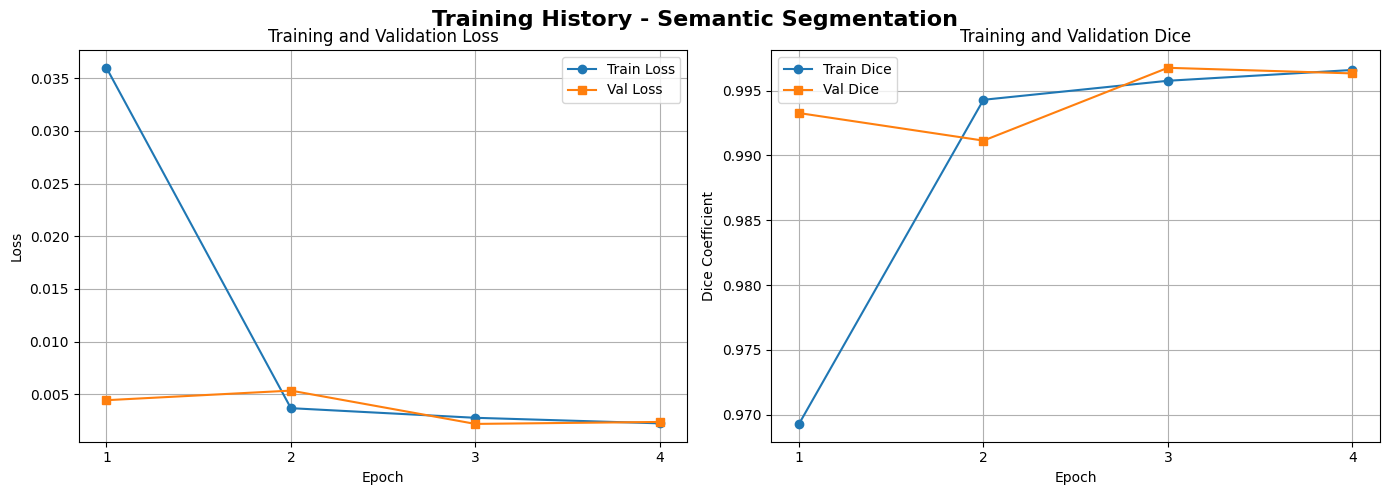


Training history saved as 'training_history_semantic_segmentation.png'


In [42]:
print("\n" + "="*70)
print("Q4: SEMANTIC SEGMENTATION")
print("="*70)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Hyperparameters
BATCH_SIZE_Q4 = 64
NUM_EPOCHS_Q4 = 4
LEARNING_RATE_Q4 = 0.001
VAL_SPLIT_Q4 = 0.1

# Prepare dataset
print("\nPreparing semantic segmentation dataset...")
train_image_dir_q4 = 'semantic_segmentation/train/images'
train_mask_dir_q4 = 'semantic_segmentation/train/masks'

# Get all image files
image_files_q4 = sorted(os.listdir(train_image_dir_q4))

# Split into train and validation
train_files_q4, val_files_q4 = train_test_split(
    image_files_q4, test_size=VAL_SPLIT_Q4, random_state=42
)

print(f"Training samples: {len(train_files_q4)}")
print(f"Validation samples: {len(val_files_q4)}")

# Create datasets
train_dataset_q4 = SemanticSegmentationDataset(
    train_image_dir_q4, train_mask_dir_q4, train_files_q4
)
val_dataset_q4 = SemanticSegmentationDataset(
    train_image_dir_q4, train_mask_dir_q4, val_files_q4
)

test_image_dir_q4 = 'semantic_segmentation/test/images'
test_mask_dir_q4 = 'semantic_segmentation/test/masks'
test_files_q4 = sorted(os.listdir(test_image_dir_q4))
test_dataset_q4 = SemanticSegmentationDataset(
    test_image_dir_q4, test_mask_dir_q4, test_files_q4
)

print(f"Test samples: {len(test_files_q4)}")

# Create data loaders
train_loader_q4 = DataLoader(
    train_dataset_q4, batch_size=BATCH_SIZE_Q4, shuffle=True, num_workers=2
)
val_loader_q4 = DataLoader(
    val_dataset_q4, batch_size=BATCH_SIZE_Q4, shuffle=False, num_workers=2
)
test_loader_q4 = DataLoader(
    test_dataset_q4, batch_size=BATCH_SIZE_Q4, shuffle=False, num_workers=2
)

# Initialize model
print("\nInitializing Semantic Segmentation U-Net...")
model_q4 = SemanticSegmentationUNet(in_channels=1, num_classes=11).to(device)

# Count parameters
total_params_q4 = sum(p.numel() for p in model_q4.parameters())
trainable_params_q4 = sum(p.numel() for p in model_q4.parameters() if p.requires_grad)
print(f"Total parameters: {total_params_q4:,}")
print(f"Trainable parameters: {trainable_params_q4:,}")

# Loss function and optimizer
criterion_q4 = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer_q4 = optim.Adam(model_q4.parameters(), lr=LEARNING_RATE_Q4)

# Train model
history_q4 = train_semantic_model(
    model_q4, train_loader_q4, val_loader_q4,
    criterion_q4, optimizer_q4, NUM_EPOCHS_Q4, device
)

# Plot training history
print("\nPlotting training history...\n")
plot_semantic_training_history(history_q4)

# **Evaluate and Visualize**


Loading best model...

EVALUATING ON TEST SET


Testing: 100%|██████████| 782/782 [00:57<00:00, 13.67it/s]


Overall Test Dice Coefficient: 0.9929 (99.29%)

----------------------------------------------------------------------
Per-Class Dice Coefficient:
Class           Dice Score     
----------------------------------------------------------------------
Background      0.9995
Digit 0         0.9948
Digit 1         0.9909
Digit 2         0.9933
Digit 3         0.9939
Digit 4         0.9912
Digit 5         0.9915
Digit 6         0.9933
Digit 7         0.9910
Digit 8         0.9934
Digit 9         0.9891

Visualizing predictions...



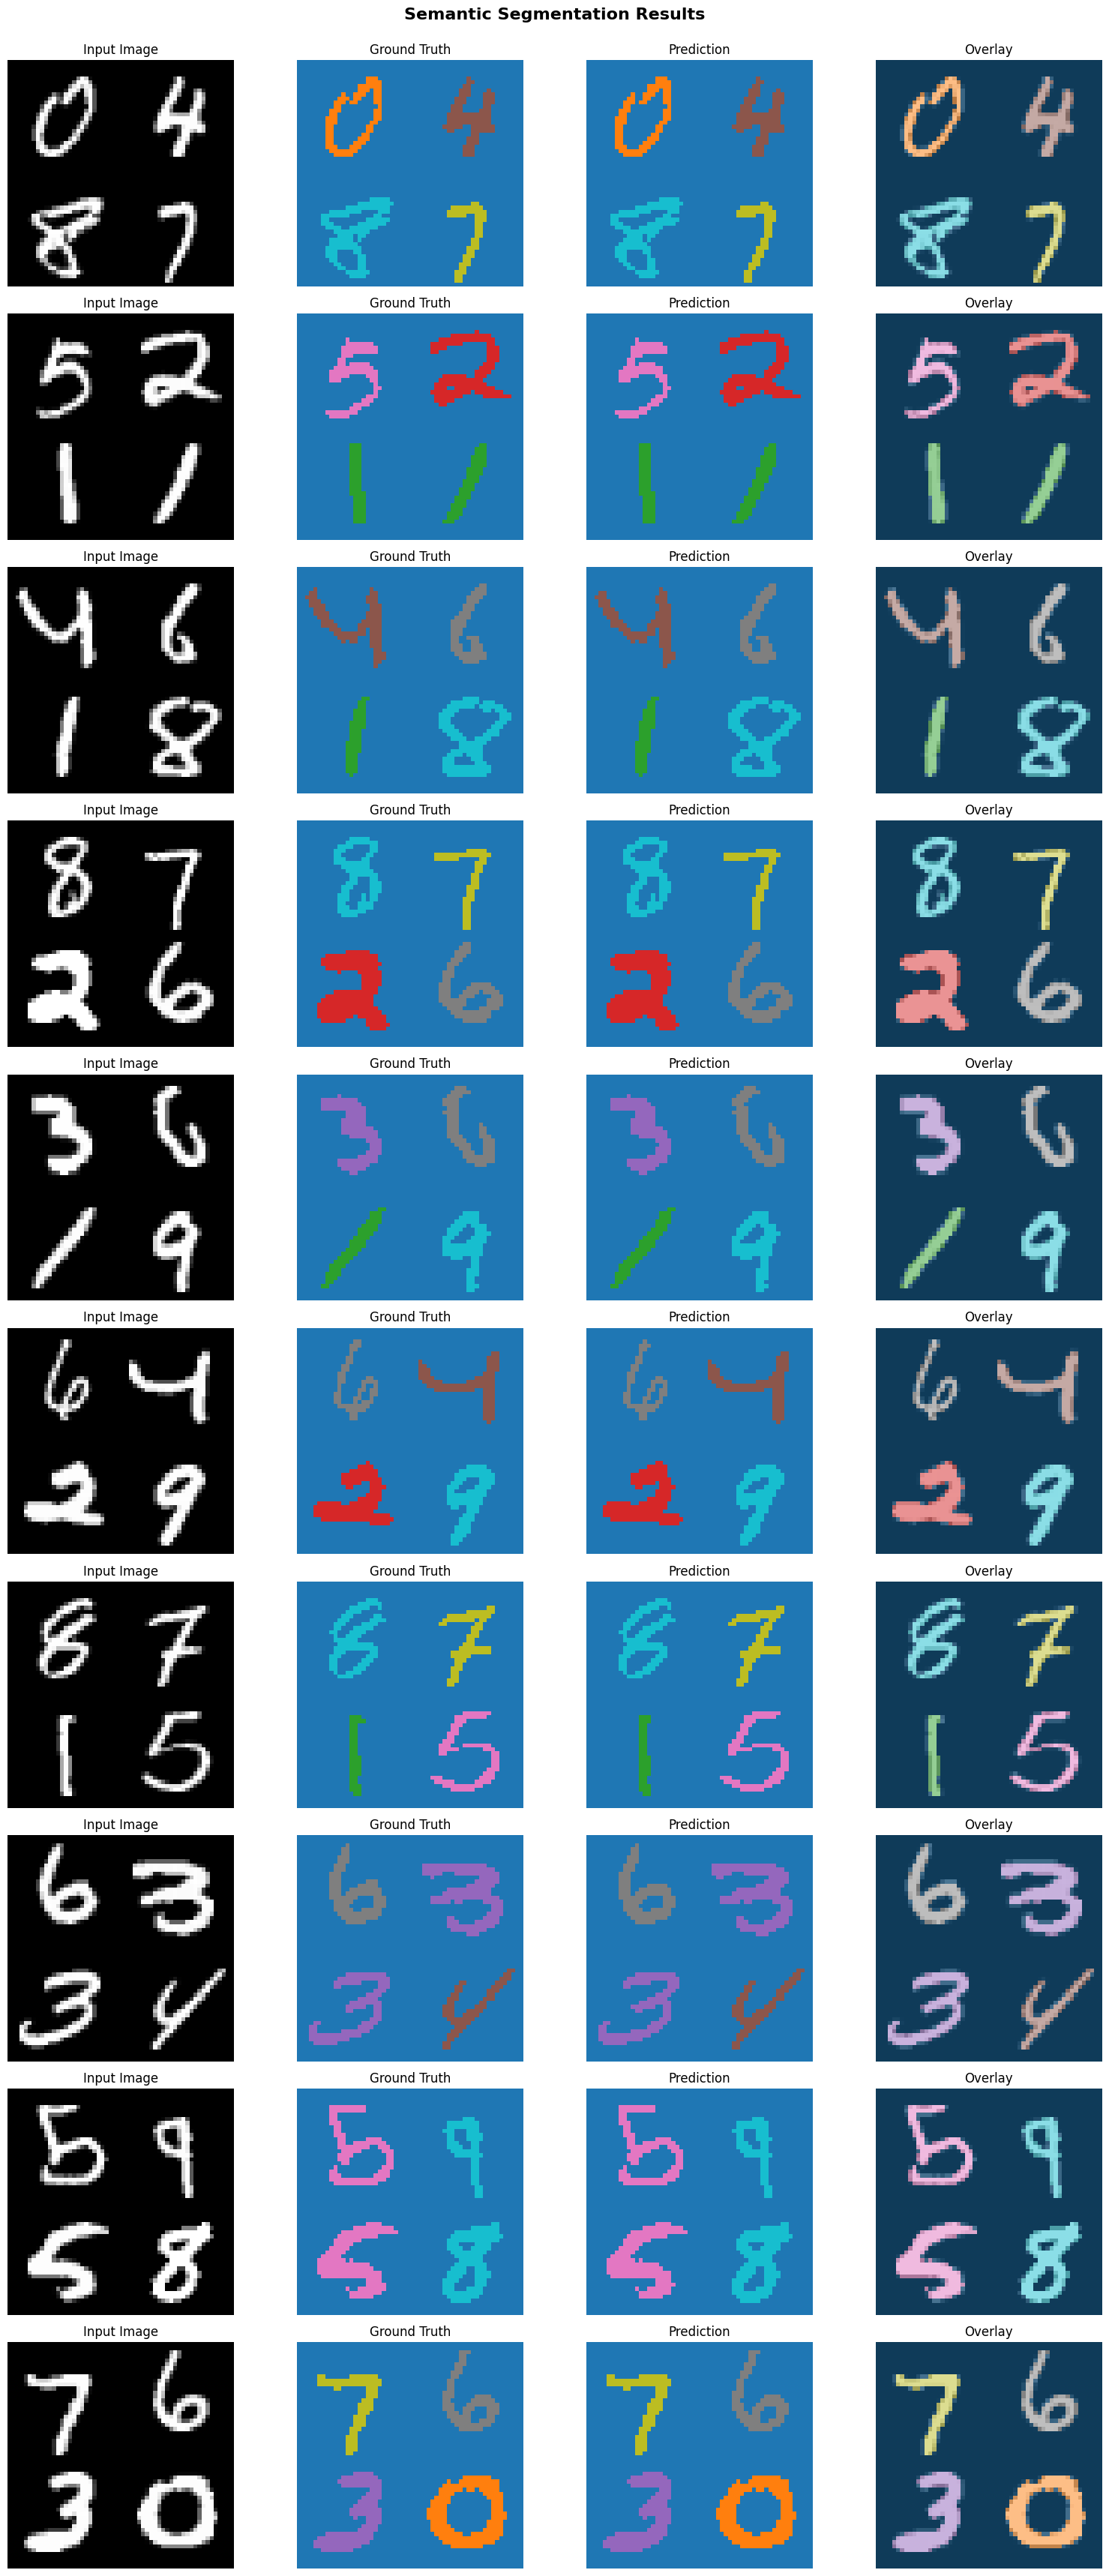


Predictions saved as 'prediction_results_semantic_segmentation.png'

FINAL RESULTS - SEMANTIC SEGMENTATION
Best Validation Dice: 0.9968 (99.68%)
Test Dice:            0.9929 (99.29%)

Saved files:
  - Model: best_semantic_segmentation_model.pth
  - Training history: training_history_semantic_segmentation.png
  - Predictions: prediction_results_semantic_segmentation.png


In [43]:
# Load best model
print("\nLoading best model...")
model_q4.load_state_dict(torch.load('best_semantic_segmentation_model.pth'))

# Evaluate on test set
test_dice_q4, class_dice_q4 = evaluate_semantic_model(model_q4, test_loader_q4, device)

# Visualize predictions
print("\nVisualizing predictions...\n")
visualize_semantic_predictions(model_q4, test_loader_q4, device, num_samples=10)

# Print final summary
print("\n" + "="*70)
print("FINAL RESULTS - SEMANTIC SEGMENTATION")
print("="*70)
print(f"Best Validation Dice: {max(history_q4['val_dice']):.4f} ({max(history_q4['val_dice'])*100:.2f}%)")
print(f"Test Dice:            {test_dice_q4:.4f} ({test_dice_q4*100:.2f}%)")
print("="*70)
print("\nSaved files:")
print("  - Model: best_semantic_segmentation_model.pth")
print("  - Training history: training_history_semantic_segmentation.png")
print("  - Predictions: prediction_results_semantic_segmentation.png")
print("="*70)

# **ZIP MODELS, DATASETS**

In [53]:
import zipfile
import os
from datetime import datetime

# Configuration
BASE_PATH = '/content'
# Change output path to local directory
OUTPUT_ZIP = f'/content/Assignment02.zip'

# Datasets
DATASETS = [
    'foreground_segmentation',
    'circular_classification',
    'semantic_segmentation'
]
# Models
MODELS = [
    'best_foreground_model.pth',
    'best_circular_classification_model.pth',
    'best_semantic_segmentation_model.pth'
]

# Plots
RESULTS = [
    'training_history_foreground_extraction.png',
    'prediction_results_foreground_extraction.png',
    'training_history_circular_classification.png',
    'prediction_results_circular_classification.png',
    'training_history_semantic_segmentation.png',
    'prediction_results_semantic_segmentation.png'
]

print("="*70)
print("CREATING ZIP FILE")
print("="*70)

# Check what exists
print("\nChecking files...")
total_size = 0

with zipfile.ZipFile(OUTPUT_ZIP, 'w', zipfile.ZIP_DEFLATED) as zipf:

    # 1. Add Datasets
    print("\n Adding Datasets:")
    for dataset in DATASETS:
        dataset_path = os.path.join(BASE_PATH, dataset)
        if os.path.exists(dataset_path):
            file_count = 0
            for root, dirs, files in os.walk(dataset_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, BASE_PATH)
                    zipf.write(file_path, arcname)
                    total_size += os.path.getsize(file_path)
                    file_count += 1
            print(f" {dataset}: {file_count:,} files")
        else:
            print(f" {dataset}: NOT FOUND")

    # 2. Add Models
    print("\n Adding Models:")
    for model in MODELS:
        model_path = os.path.join(BASE_PATH, model)
        if os.path.exists(model_path):
            zipf.write(model_path, model)
            size = os.path.getsize(model_path)
            total_size += size
            print(f" {model}: {size / (1024**2):.2f} MB")
        else:
            print(f" {model}: NOT FOUND")

    # 3. Add Plots
    print("\n Adding Results:")
    for result in RESULTS:
        result_path = os.path.join(BASE_PATH, result)
        if os.path.exists(result_path):
            zipf.write(result_path, result)
            print(f" {result}")
        else:
            print(f" {result}: NOT FOUND")

print("\n" + "="*70)
print(f"Zip file created at: {OUTPUT_ZIP}")
print(f"Total size of zipped content: {total_size / (1024**2):.2f} MB")
print("="*70)

CREATING ZIP FILE

Checking files...

 Adding Datasets:
 foreground_segmentation: 140,001 files
 circular_classification: 280,001 files
 semantic_segmentation: 500,002 files

 Adding Models:
 best_foreground_model.pth: 118.51 MB
 best_circular_classification_model.pth: 121.02 MB
 best_semantic_segmentation_model.pth: 118.51 MB

 Adding Results:
 training_history_foreground_extraction.png
 prediction_results_foreground_extraction.png
 training_history_circular_classification.png
 prediction_results_circular_classification.png
 training_history_semantic_segmentation.png
 prediction_results_semantic_segmentation.png

Zip file created at: /content/Assignment02.zip
Total size of zipped content: 723.94 MB


In [54]:
from google.colab import files

# Provide the ziped file path
OUTPUT_ZIP = '/content/Assignment02.zip'
try:
    files.download(OUTPUT_ZIP)
    print(f"\nProviding download link for: {OUTPUT_ZIP}")
except NameError:
    print("Error: OUTPUT_ZIP variable not found. Please ensure the variable containing the zip file path is defined.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {OUTPUT_ZIP}. Please check the file path.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Providing download link for: /content/Assignment02.zip
